# Time Series Forecasting - Predicting Sales 📈

# *Purpose*

The purpose of this notebook is to predict sales of Favorita, a corporation located in South America’s west coast Ecuador, using Time Series Forecasting Models.

## *About the Company*

**Corporación Favorita** is an Ecuadorian company that invests inside and outside the country. Its activities cover the commercial, industrial and real estate areas; and its presence extends to more than 5 countries in the region.

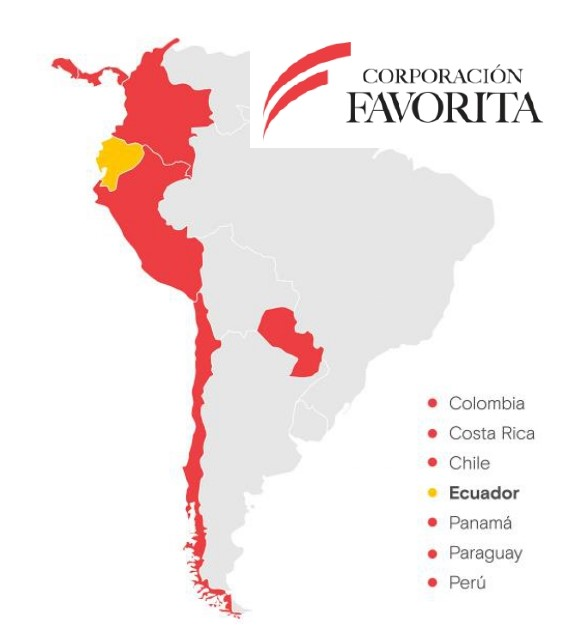

## *Objective*

The **objective of this project is to use time series forecasting to predict the sales of Favorita Corporation**. We aim to build a model that can accurately predict sales of different "families" of products, using a training dataset that includes dates, shops, and information about items, promotions and unit sales. 
- It is hoped that the model can improve forecasting capabilities for retail businesses, which can help ensure that retailers have the right products available at the right time. 
- The problem of forecasting for retail is complex due to factors such as new locations, unique needs, new products, seasonal changes and unpredictable product merchandising, and this competition hopes to offer a solution using machine learning.

## *About the data*

The data provided includes the details of 54 stores and 33 product families, with time series starting from 2013-01-01 and ending in 2017-08-31.

6 different types of data: train, test, store, transactions, holidays and events, and daily oil price.
- Srain: Time series information for store and product family combinations, with the sales column indicating the total sales for a product at a particular store on a given date.
- Stores: Time series information for store and product family combinations, with the sales column indicating the total sales for a product at a particular store on a given date.
- Transactions: Information about sales. 
- Holidays: Metadata. Helpful in seasonal analysis.
- Oil Price: Apparently the country react to shocks in the oil industry, which would be useful for the model.

## 1. Libraries

In [1]:
# BASE
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
plt.style.use('ggplot')

# Addtional packages (models, etc.)
from sklearn.linear_model import LinearRegression
from pathlib import Path
from warnings import simplefilter
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
import ipywidgets as widgets
from learntools.time_series.utils import (create_multistep_example,
                                          load_multistep_data,
                                          make_lags,
                                          make_multistep_target,
                                          plot_multistep)

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


## 2. Read the data

In [2]:
path = '/kaggle/input/store-sales-time-series-forecasting/'
os.listdir(path)

['oil.csv',
 'sample_submission.csv',
 'holidays_events.csv',
 'stores.csv',
 'train.csv',
 'test.csv',
 'transactions.csv']

In [3]:
oil = pd.read_csv(path+'oil.csv')
train_data = pd.read_csv(path+'train.csv', index_col=0)
test_data = pd.read_csv(path+'test.csv', index_col=0)
samp_subm = pd.read_csv(path+'sample_submission.csv')
holidays = pd.read_csv(path+'holidays_events.csv')
stores =  pd.read_csv(path+'stores.csv')
data_trans = pd.read_csv(path+'transactions.csv')

## 3. Data Exploration

### *Oil effect*

Oil has seen a substantial fall until February 2016, since then, the price has been stabilising and recovering to current levels. A priori, following the logic that oil influences consumers' purchasing patterns, one would expect lower purchases throughout August 2014-February 2015. We can inspect this in detail during the seasonal analysis.

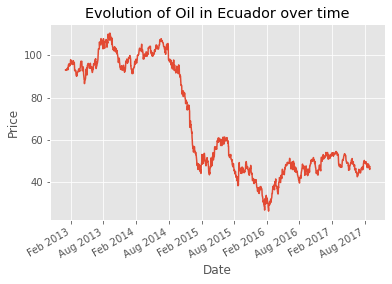

In [4]:
oil.fillna(method='bfill',inplace=True)
# Scaling x-axis:
oil['date'] = pd.to_datetime(oil['date'])
n = 6  # Keep every 6th month
ax = plt.gca()


ax.xaxis.set_major_locator(mdates.MonthLocator(interval=n))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Evolution of Oil
plt.plot(oil['date'], oil['dcoilwtico'])
plt.xlabel('Date')
plt.gcf().autofmt_xdate()
plt.ylabel('Price')
plt.title('Evolution of Oil in Ecuador over time')
plt.show()

### *Sales*

In this section we explore broadly how sales have fared under different criteria.

In [5]:
train_data.head()

date  store_nbr      family  sales  onpromotion
id                                                       
0   2013-01-01          1  AUTOMOTIVE    0.0            0
1   2013-01-01          1   BABY CARE    0.0            0
2   2013-01-01          1      BEAUTY    0.0            0
3   2013-01-01          1   BEVERAGES    0.0            0
4   2013-01-01          1       BOOKS    0.0            0

### *Sales: Sales per Store*

We can see that shops 44, 45, 3 and 47 bring in the most sales for the company. This may be due to a variety of reasons (the size of the shop, for example), so we cannot be too quick to make recommendations based on this alone. However, it may be useful to target more promotions to these shops, because they bring in more customers.

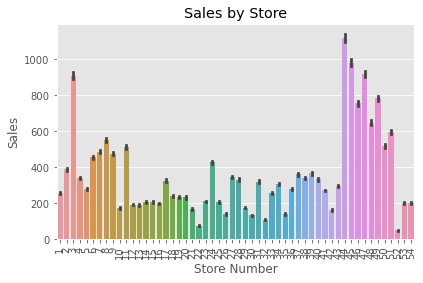

In [6]:
sns.barplot(x='store_nbr', y='sales', data=train_data)
plt.xlabel("Store Number")
plt.ylabel("Sales")
plt.title("Sales by Store")
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

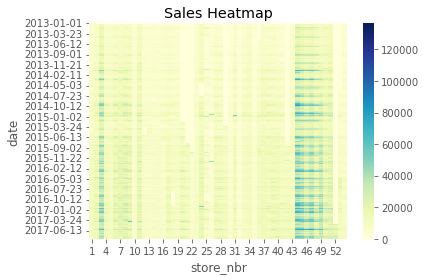

In [7]:
data_pivot = train_data.pivot_table(index='date', columns='store_nbr', values='sales', aggfunc='sum')
sns.heatmap(data_pivot, cmap='YlGnBu')
plt.title("Sales Heatmap")
plt.tight_layout()
plt.show()

It appears that shops 3, and those between 43-49 are the most active, and generate the most sales for the franchise.


### *Sales: Best-Sellers*

But what is sold in these shops that have a large number of receptions? Maybe the following will give us a grasp. 

The following visualization shows how Grocery I, Beverages and Produce categories are the most frequently sold products in Favorita's product range. We can keep these three as potential inputs for the models we will build later.

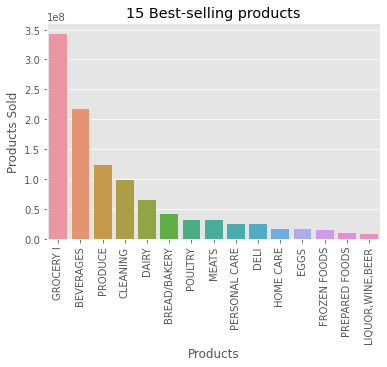

In [8]:
best_15 = train_data.groupby(['family'])['sales'].sum().reset_index()
best_15 = best_15.sort_values(by='sales', ascending=False).head(15)
sns.barplot(x='family', y='sales', data=best_15)
plt.xlabel("Products")
plt.ylabel("Products Sold")
plt.title("15 Best-selling products")
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

### *Sales: Weekly average sales*

It can be seen how grouping the sales of all products and obtaining the total average sales per week gives an approximation that can be used for simpler forecasting models.

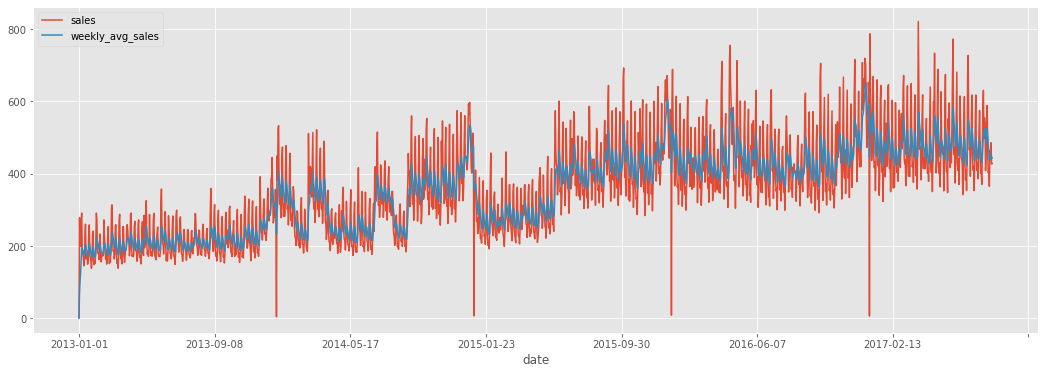

In [9]:
avg_sales = train_data.groupby('date').agg({'sales': 'mean'}).reset_index()
#daily_avg_sales['weekly_avg_sales'] = daily_avg_sales['sales'].rolling(window=7).mean()
avg_sales['weekly_avg_sales'] = avg_sales['sales'].ewm(span=7, adjust=False).mean()
#ax = daily_avg_sales.set_index('date').plot(figsize = (16, 8))
ax1 = avg_sales.plot(x= 'date', y= ['sales', 'weekly_avg_sales'], figsize=(18,6))

### *Sales: Sales during Holidays*

In this section we check how sales vary during Holidays. At a glance, it can be seen that during these dates, sales tend to decrease. 

In [10]:
holidays.head()

date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False

In [11]:
holidays['type'].value_counts()

Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: type, dtype: int64

In [12]:
# Creating a df of day type  and avg_sales, avg was already created before
day_type = holidays[['date', 'type']]
df_1 = pd.merge(day_type, avg_sales, on='date')
df_1.reset_index(drop = True, inplace= True)

Text(0.5, 1.0, 'Average Holiday Sales')

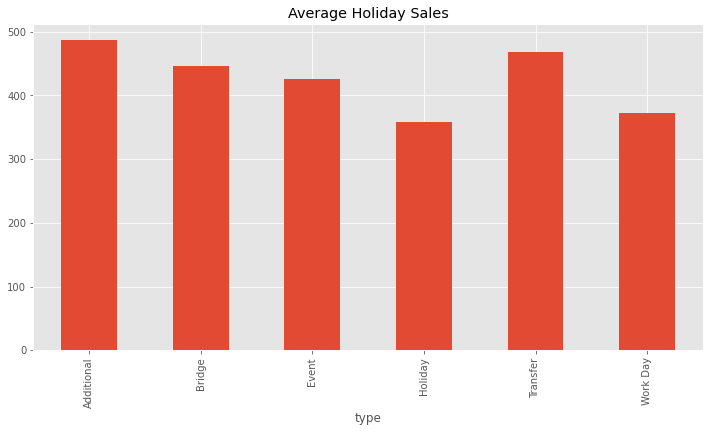

In [13]:
df_2 = df_1.groupby(['type']).mean(numeric_only=True)['sales']
average_holiday_sales = df_1.mean(numeric_only=True)
df_2.plot(kind='bar', figsize = (12,6)).set_title('Average Holiday Sales')

_________

## 4.Creating a model

### *4.1. Linear Regression*

Linear regression is widely used in practice, and is a good starting point to begin predicting even complex tasks. The linear regression algorithm learns to perform a weighted sum from its input features.

In particular this regression uses the average calculated per week of sales, you can try different timeframes (e.g. monthly), compare them and get more interesting results.

In [14]:
avg_sales.head()

date       sales  weekly_avg_sales
0  2013-01-01    1.409438          1.409438
1  2013-01-02  278.390807         70.654780
2  2013-01-03  202.840197        103.701135
3  2013-01-04  198.911154        127.503640
4  2013-01-05  267.873244        162.596041

In [15]:
avg_sales_2 = avg_sales.drop('weekly_avg_sales',axis='columns')
avg_sales_2['time'] = np.arange(len(avg_sales))
avg_sales_2.head()

date       sales  time
0  2013-01-01    1.409438     0
1  2013-01-02  278.390807     1
2  2013-01-03  202.840197     2
3  2013-01-04  198.911154     3
4  2013-01-05  267.873244     4

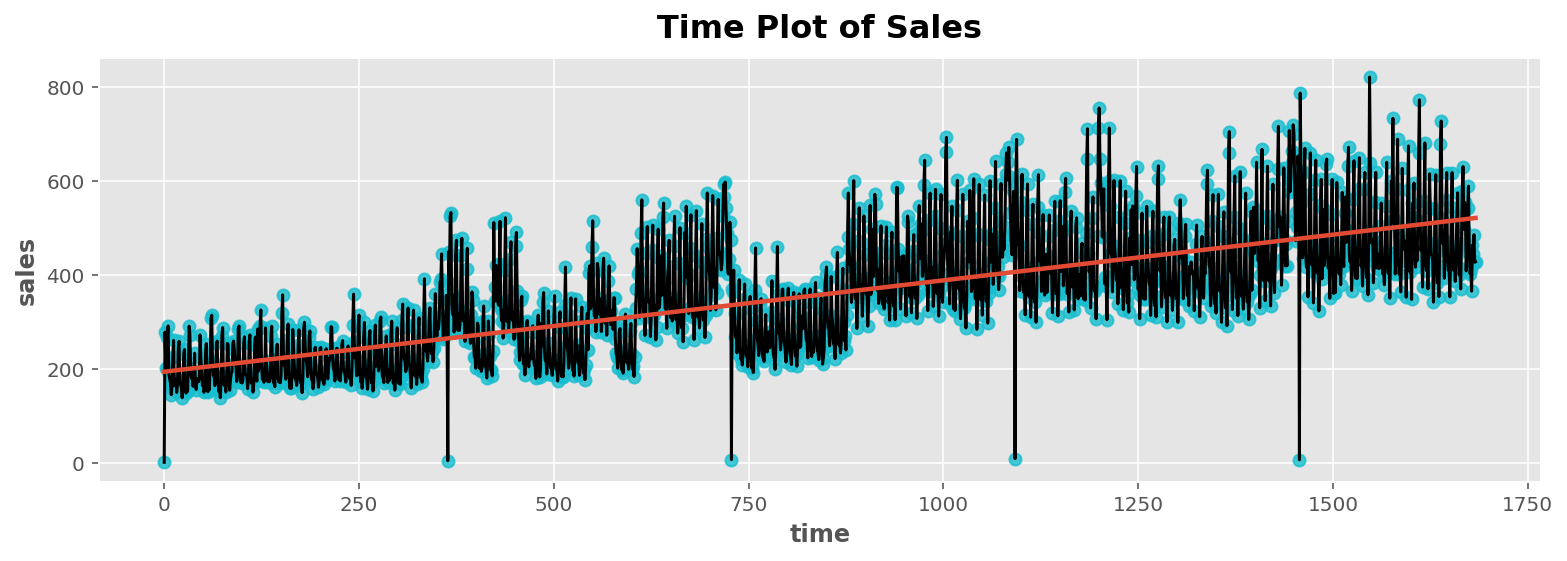

In [16]:
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots()
ax.plot('time', 'sales', data=avg_sales_2, color='black')
ax = sns.regplot(x='time', y='sales', data=avg_sales_2, ci=None, scatter_kws=dict(color='#17becf'))
ax.set_title('Time Plot of Sales');

### *4.2. Lags*

Lag features are values at prior timesteps (1 timestep for this exercise) that are  useful because they are created on the assumption that what happened in the past can influence or contain a sort of intrinsic information about the near future.

In [17]:
avg_sales_2['Lag_1'] = avg_sales_2['sales'].shift(1)
avg_sales_2 = avg_sales_2.reindex(columns=['date', 'sales', 'Lag_1', 'time'])

avg_sales_2.head()

date       sales       Lag_1  time
0  2013-01-01    1.409438         NaN     0
1  2013-01-02  278.390807    1.409438     1
2  2013-01-03  202.840197  278.390807     2
3  2013-01-04  198.911154  202.840197     3
4  2013-01-05  267.873244  198.911154     4

Text(0.5, 1.0, 'Lag Plot of Sales')

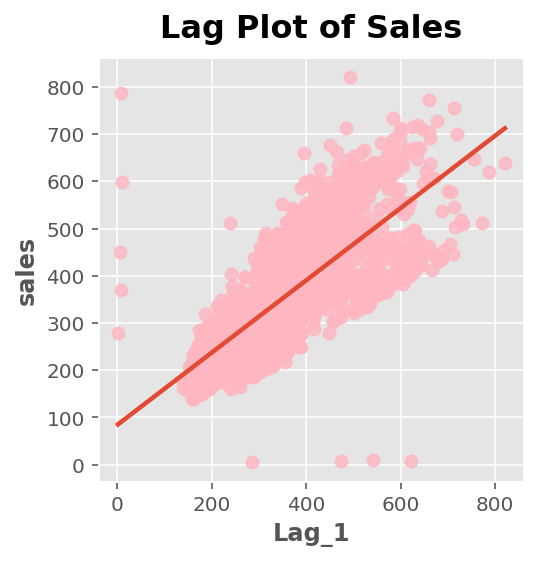

In [18]:
fig, ax = plt.subplots()
ax = sns.regplot(x = 'Lag_1', y = 'sales', data = avg_sales_2, ci = None, scatter_kws = dict(color='lightpink'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of Sales')

In [19]:
# Training data
X = avg_sales_2.loc[:, ['time']] # features
y = avg_sales_2.loc[:, 'sales'] # target
# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index = X.index)
y_pred


0       194.232790
1       194.427137
2       194.621484
3       194.815831
4       195.010178
           ...    
1679    520.541320
1680    520.735667
1681    520.930014
1682    521.124361
1683    521.318708
Length: 1684, dtype: float64

In [20]:
# Just styling, you can adjust it as you want 
plot_params = dict(
    color = '0.75',
    style = ".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

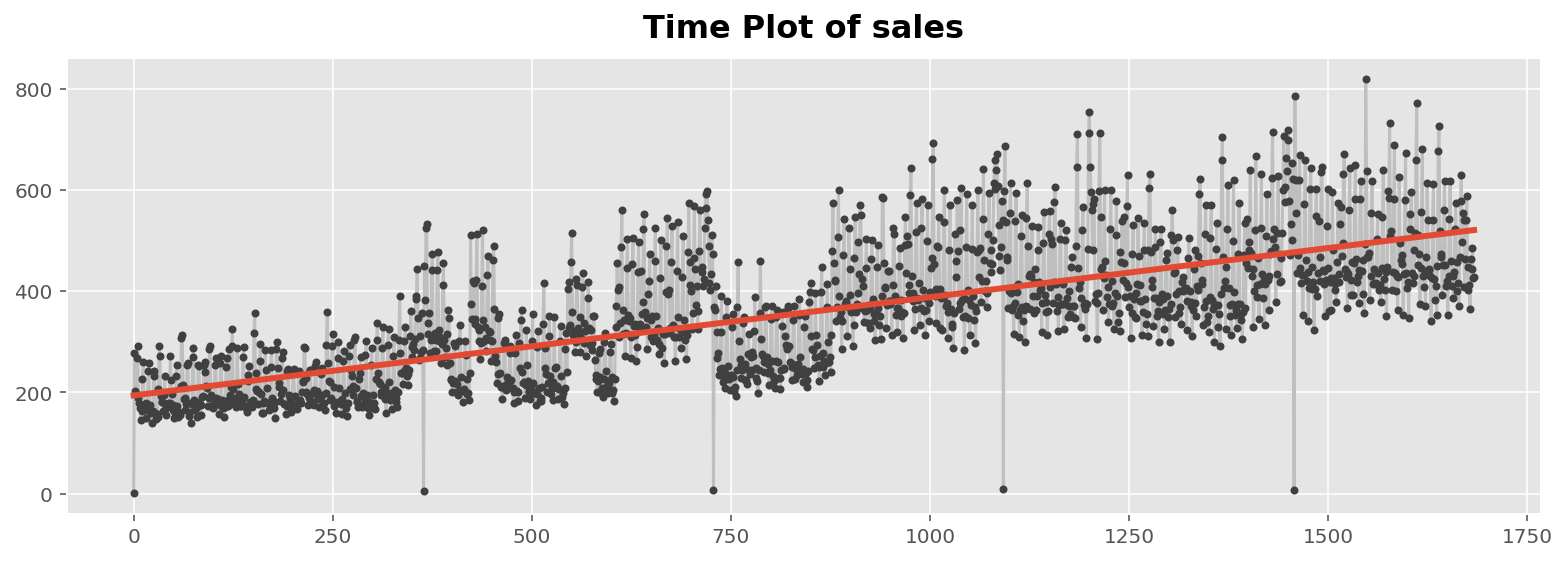

In [21]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth = 3)
ax.set_title('Time Plot of sales');

In [22]:
X = avg_sales_2.loc[:, ['Lag_1']]
X.dropna(inplace = True) # drop missing values in the feature set
y = avg_sales_2.loc[:, 'sales'] # create the target
y, X = y.align(X, join = 'inner') # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_pred

1        85.301711
2       297.268221
3       239.451339
4       236.444547
5       289.219409
           ...    
1679    363.958887
1680    439.106347
1681    424.615456
1682    455.968972
1683    410.998514
Length: 1683, dtype: float64

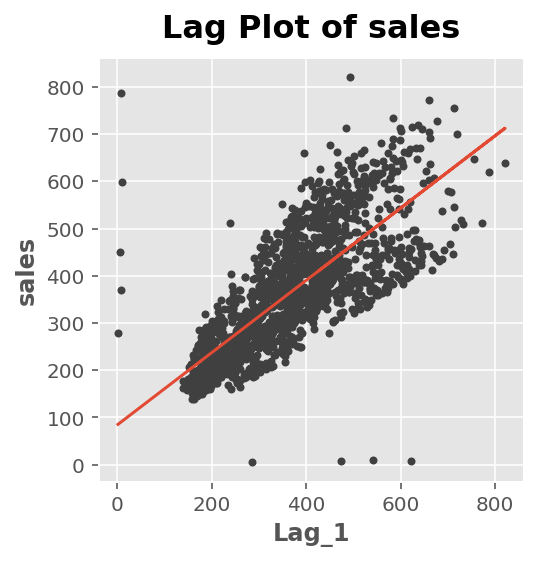

In [23]:
fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('sales')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of sales');

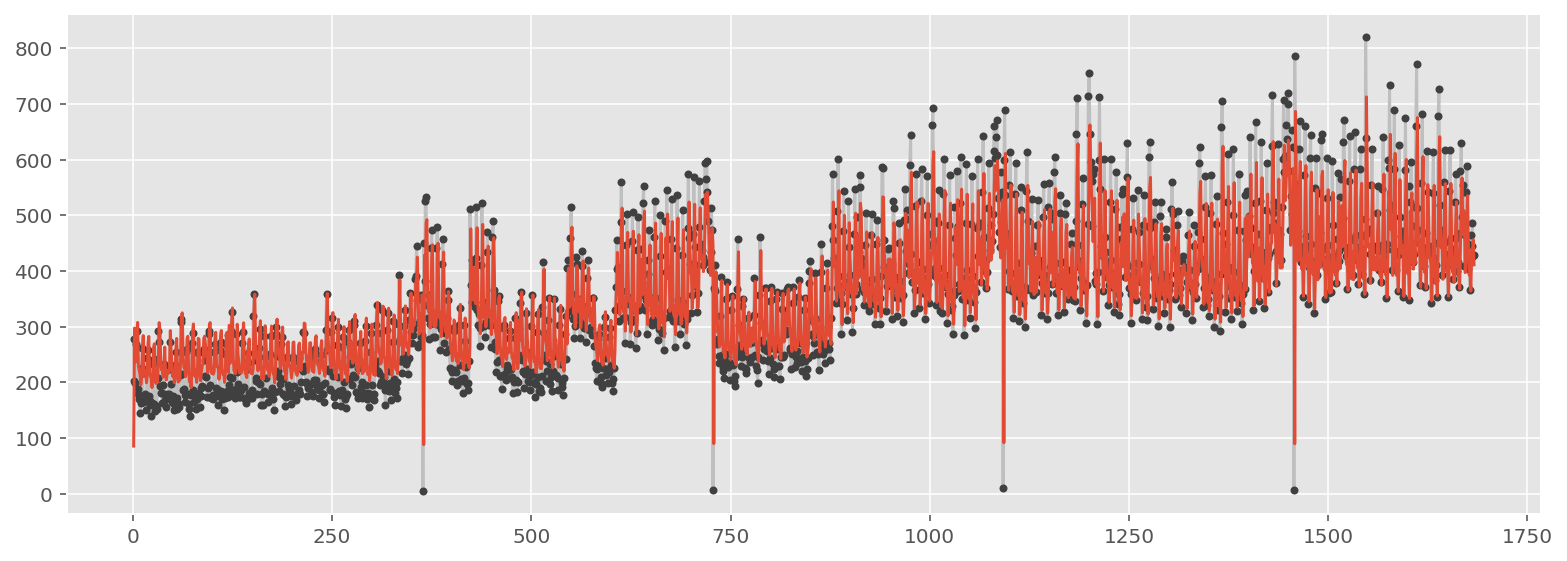

In [24]:
ax = y.plot(**plot_params)
ax = y_pred.plot()

### *4.3. Trend Analysis: Moving Averages*

The trend component of a time series represents a persistent, long-term change in the mean of the series. Within a moving average, each point on the graph represents the average of all the values in the series that fall within the window on either side. The results approximate a non-linear representation, which is ideal for capturing this trend effect in sales. 
- It is worth to mention that to capture this "trend" we have to create a linear regression first. 

In [25]:
# Formatting, disregard if you want.
simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [26]:
# Data
avg_sales_3 = train_data.groupby('date').agg({'sales': 'mean'}).reset_index()
avg_sales_3 = avg_sales_3.set_index('date')
avg_sales_3

sales
date                  
2013-01-01    1.409438
2013-01-02  278.390807
2013-01-03  202.840197
2013-01-04  198.911154
2013-01-05  267.873244
...                ...
2017-08-11  463.733851
2017-08-12  444.798280
2017-08-13  485.768618
2017-08-14  427.004717
2017-08-15  427.980884

[1684 rows x 1 columns]

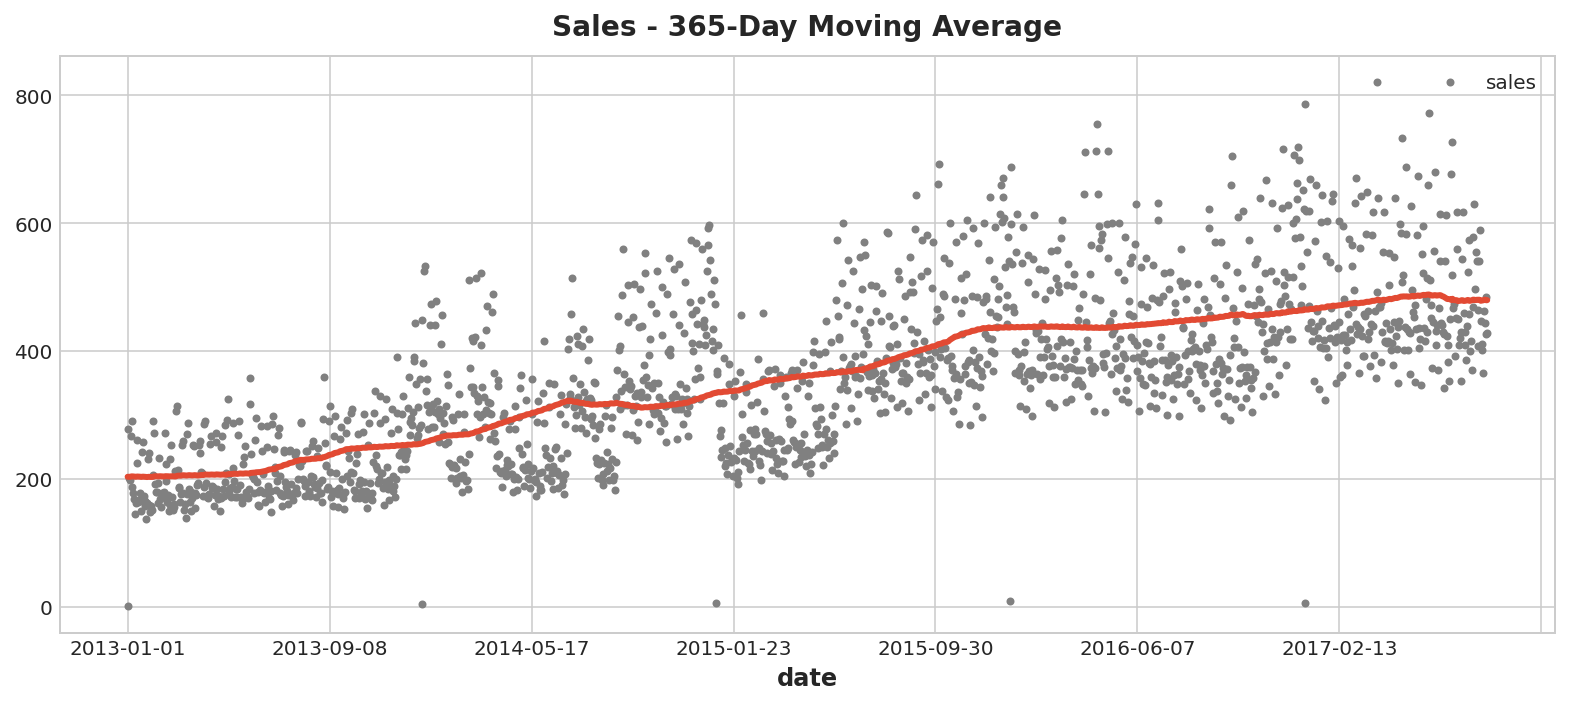

In [27]:
moving_average = avg_sales_3.rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = avg_sales_3.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Sales - 365-Day Moving Average", legend=False,
);

In [28]:
dp = DeterministicProcess(
    index=avg_sales_3.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

const  trend
date                    
2013-01-01    1.0    1.0
2013-01-02    1.0    2.0
2013-01-03    1.0    3.0
2013-01-04    1.0    4.0
2013-01-05    1.0    5.0

In [29]:
y = avg_sales_3["sales"]  # target
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_pred

date
2013-01-01    194.232790
2013-01-02    194.427137
2013-01-03    194.621484
2013-01-04    194.815831
2013-01-05    195.010178
                 ...    
2017-08-11    520.541320
2017-08-12    520.735667
2017-08-13    520.930014
2017-08-14    521.124361
2017-08-15    521.318708
Length: 1684, dtype: float64

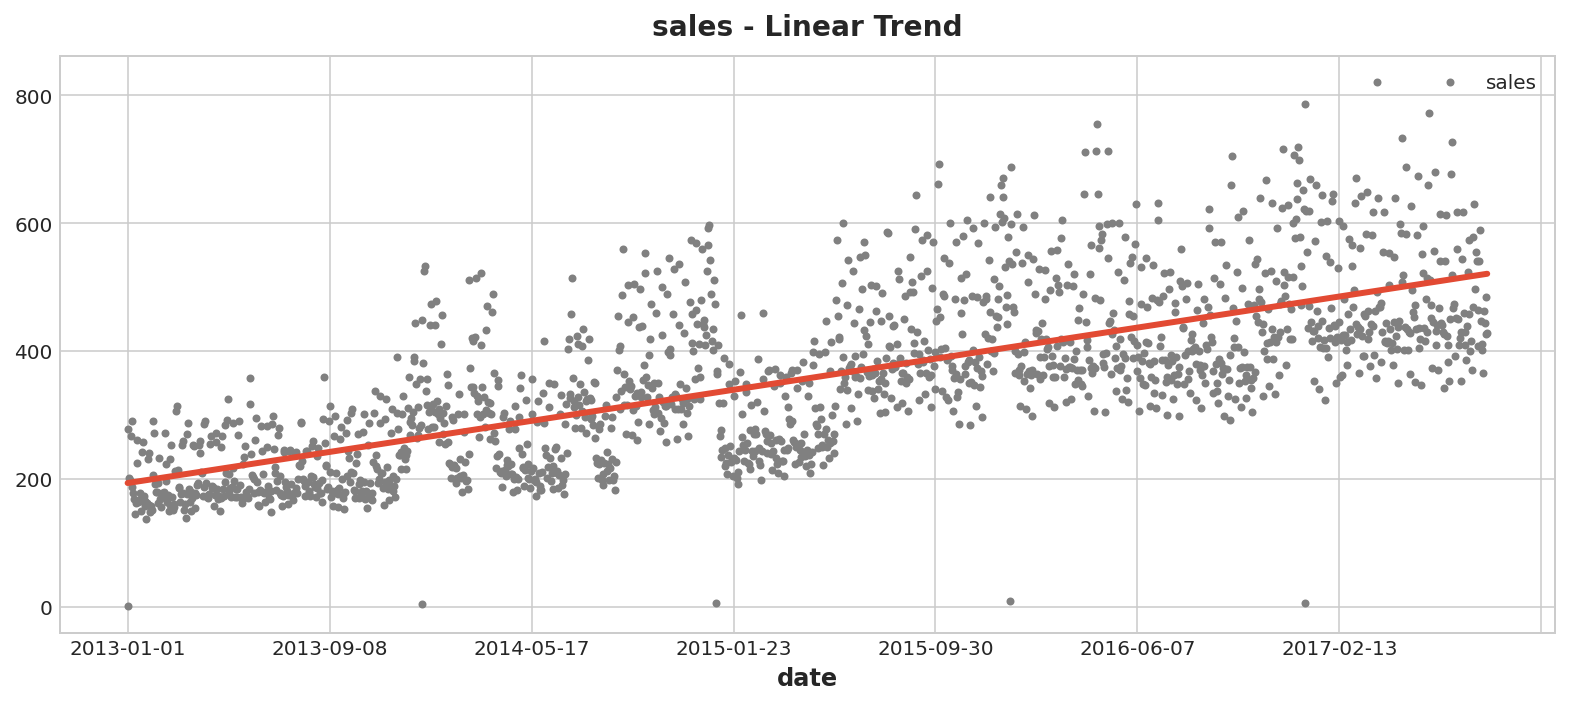

In [30]:
ax = avg_sales_3.plot(style=".", color="0.5", title="sales - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

In [31]:
# Forecasting    
X = dp.out_of_sample(steps=200)

y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()

1685    521.513055
1686    521.707402
1687    521.901749
1688    522.096096
1689    522.290443
dtype: float64

With te trend captured, we can plot the predictions for the next 200 days. 

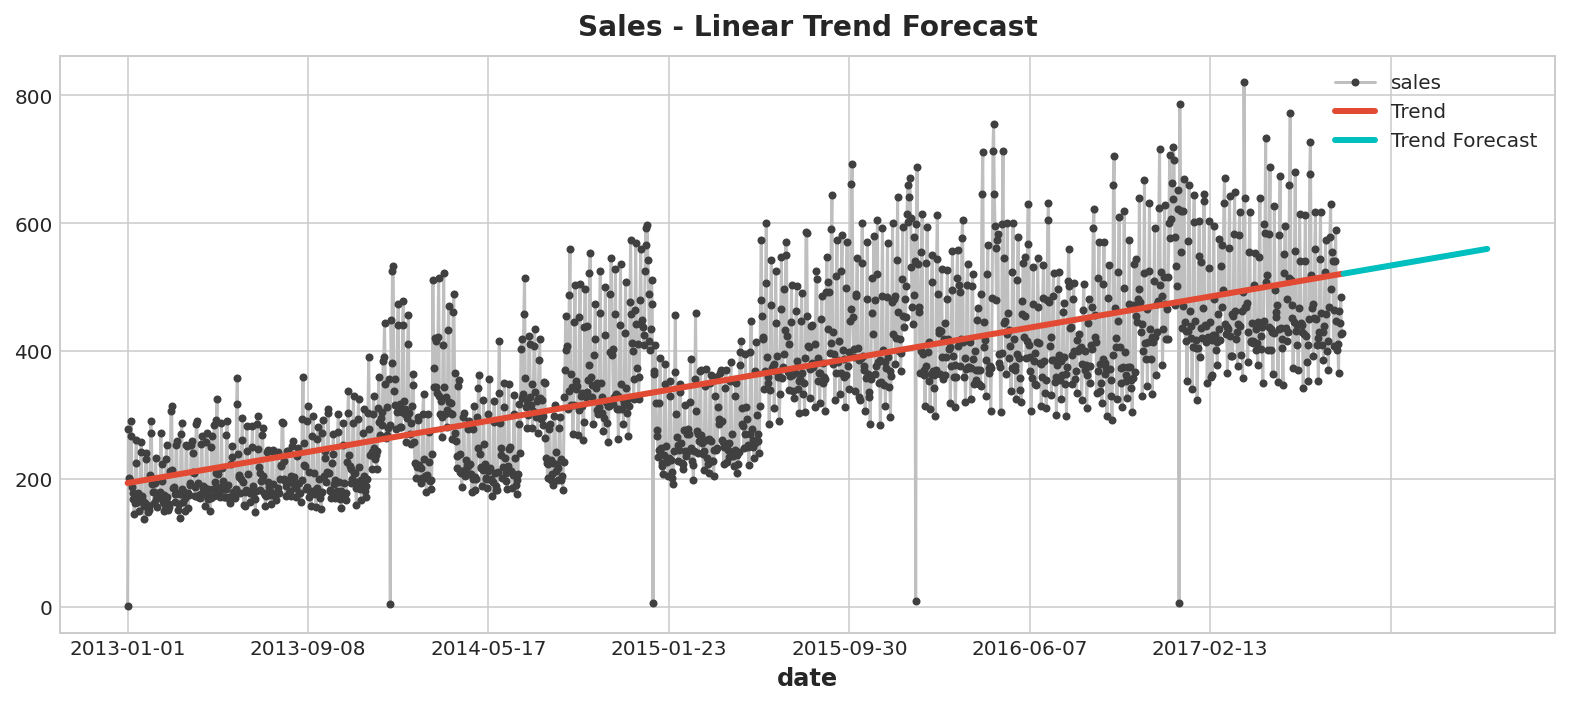

In [32]:
ax = avg_sales_3["2013-01":].plot(title="Sales - Linear Trend Forecast", **plot_params)
ax = y_pred["2013-01":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="c")
_ = ax.legend()

### *4.3. Seasonality*


We can use a seasonal plot analysis to discover seasonal patterns. In this particular scenerio is quite relevant because we can capture, for example, which days (or months) we will sell more, so the company can assure having the correct stock for this "season". 

In [33]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [34]:
train_data_a = train_data.copy()
train_data_a['date'] = pd.to_datetime(train_data_a['date'])
train_data_a.set_index("date").to_period("D")

store_nbr                      family     sales  onpromotion
date                                                                    
2013-01-01          1                  AUTOMOTIVE     0.000            0
2013-01-01          1                   BABY CARE     0.000            0
2013-01-01          1                      BEAUTY     0.000            0
2013-01-01          1                   BEVERAGES     0.000            0
2013-01-01          1                       BOOKS     0.000            0
...               ...                         ...       ...          ...
2017-08-15          9                     POULTRY   438.133            0
2017-08-15          9              PREPARED FOODS   154.553            1
2017-08-15          9                     PRODUCE  2419.729          148
2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000            8
2017-08-15          9                     SEAFOOD    16.000            0

[3000888 rows x 4 columns]

Seasonal plots over a week and over a year.

In [35]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("inferno", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="orange")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [36]:
grouped_df = train_data.groupby('date').agg({'sales': 'mean'}).reset_index()
grouped_df['date'] = pd.to_datetime(grouped_df["date"])
grouped_df["date"] = grouped_df["date"].dt.to_period("D")
grouped_df = grouped_df.set_index('date')
X = grouped_df.copy()

Below is the graph that captures the changes between seasons by day-week and by day-year. 
- As can be seen, there is a greater tendency to achieve more sales on Sundays, while intermediate days such as Thursdays tend to sell less. 
- Similarly, the second graph shows that there are seasons that are more marked and coincidentally coincide with the same sales peaks as in previous years (e.g. Christmas sales peaks). 

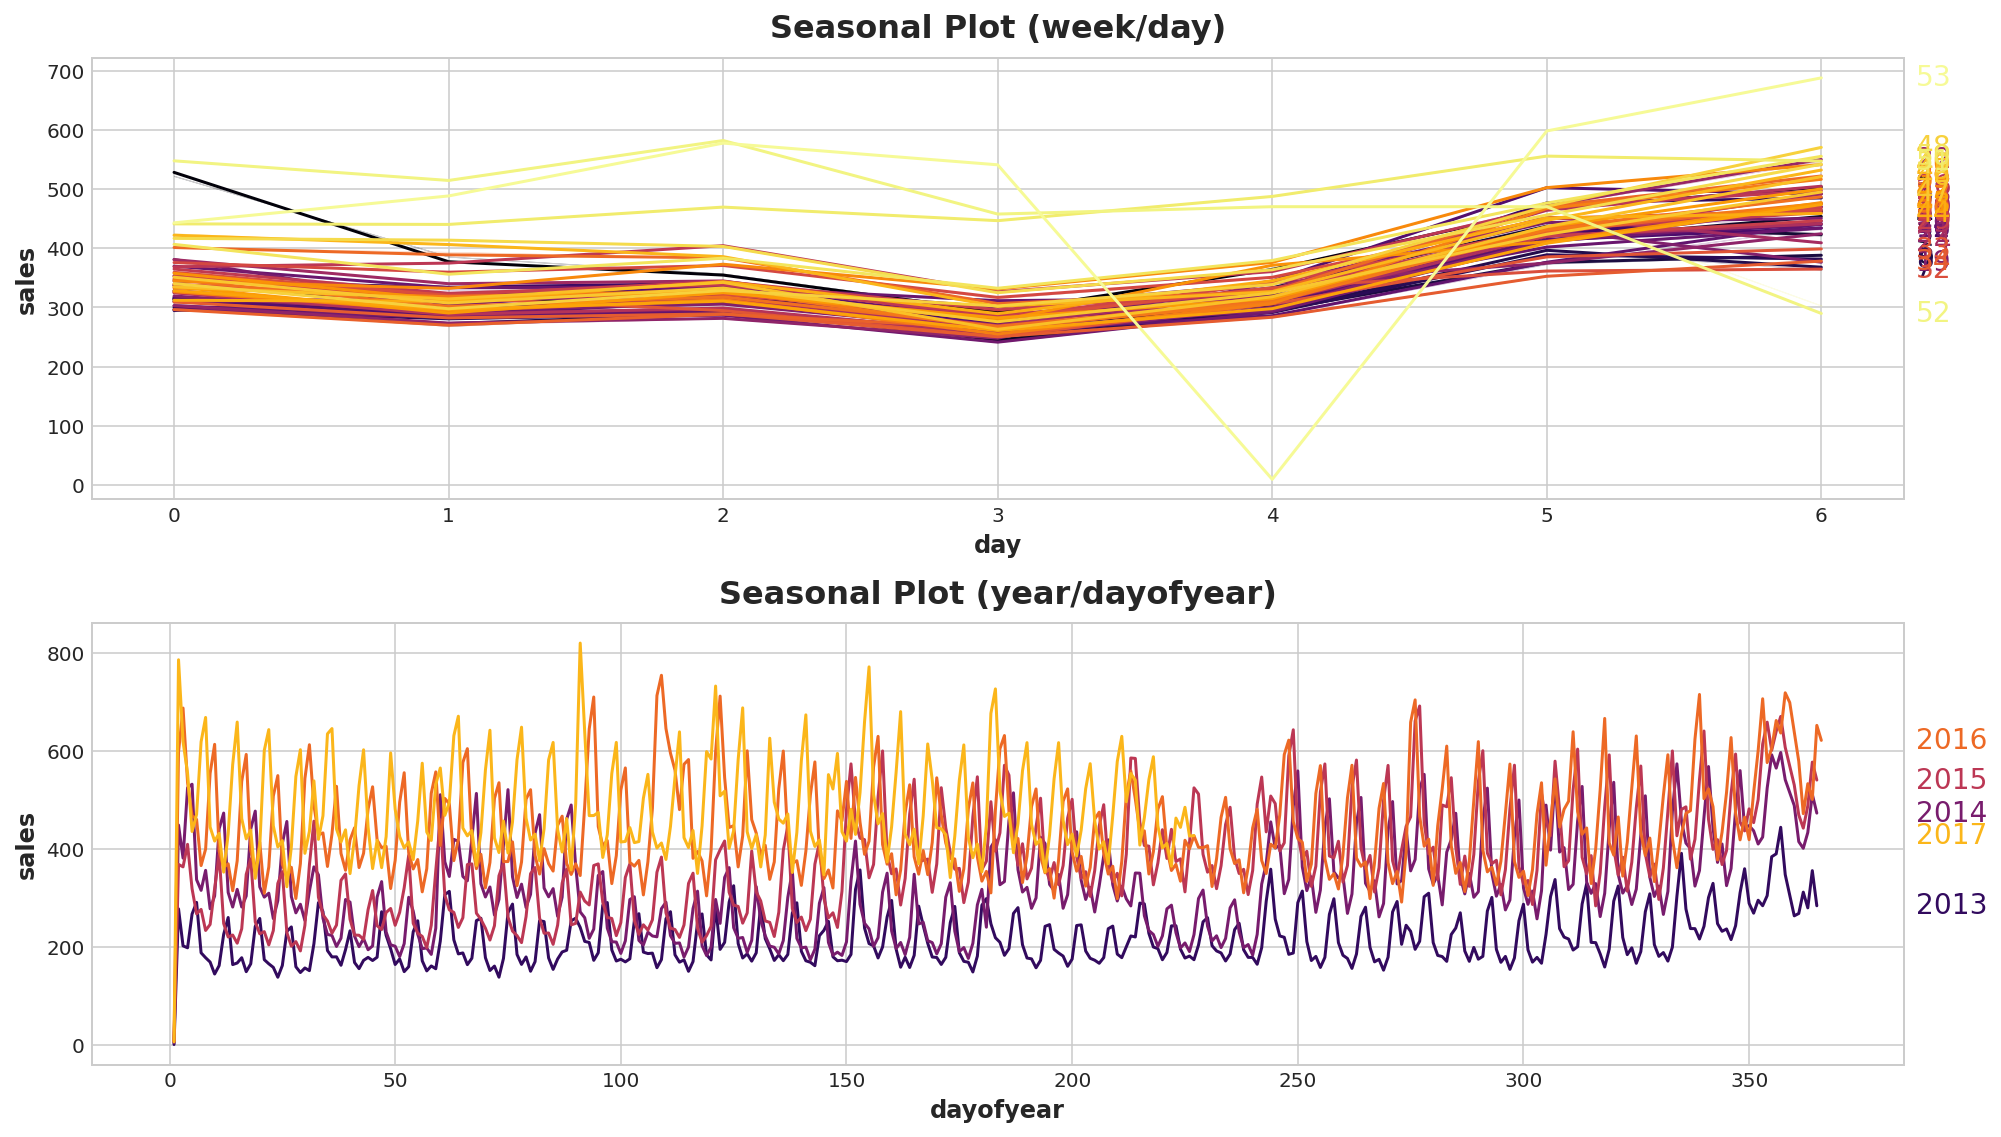

In [37]:
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(14, 8))
seasonal_plot(X, y="sales", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="sales", period="year", freq="dayofyear", ax=ax1)
ax.autoscale(enable=True, axis='y', tight=True)

### *4.3.1. Seasonality: Periodogram*

The periodogram tells you the strength of the frequencies in a time series, in other words, how many features include in the Fourier model before creating the predictions.
- If you change the number of features within the Fourier model you can notice that the predictions will vary, the interpretation can be subjetive. 

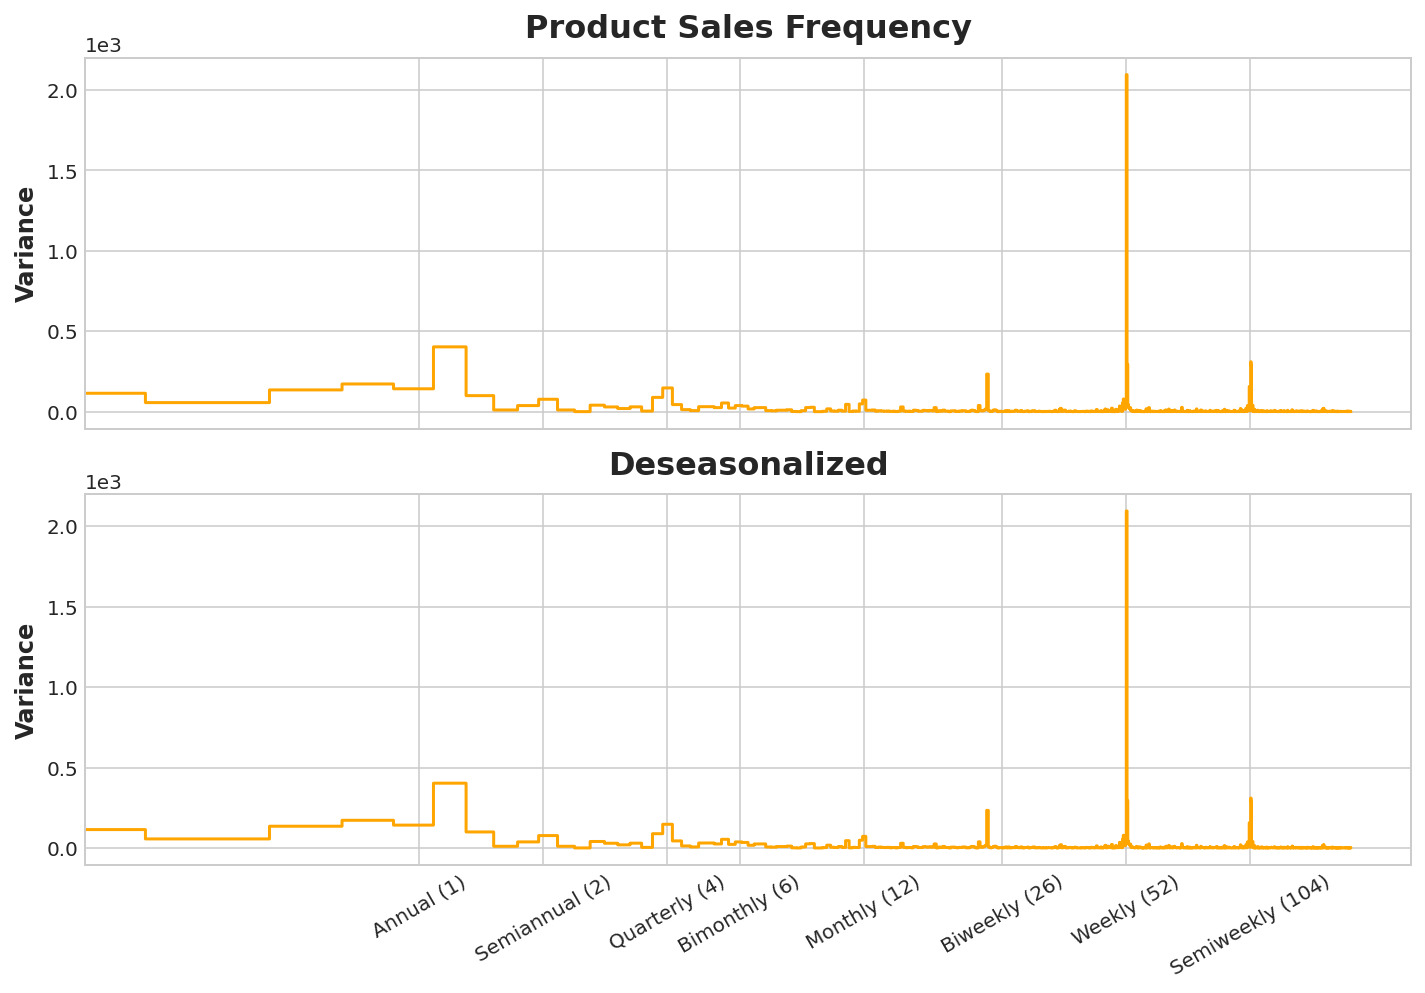

In [38]:
#plot_periodogram(avg_sales.sales);

y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

Once we defined how many Fourier features we are going to include, we can instantiate the Fourier model to check the predictions for the next 180 days based on the seasonality patterns found.

In [39]:
fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=X.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in grouped_df.index

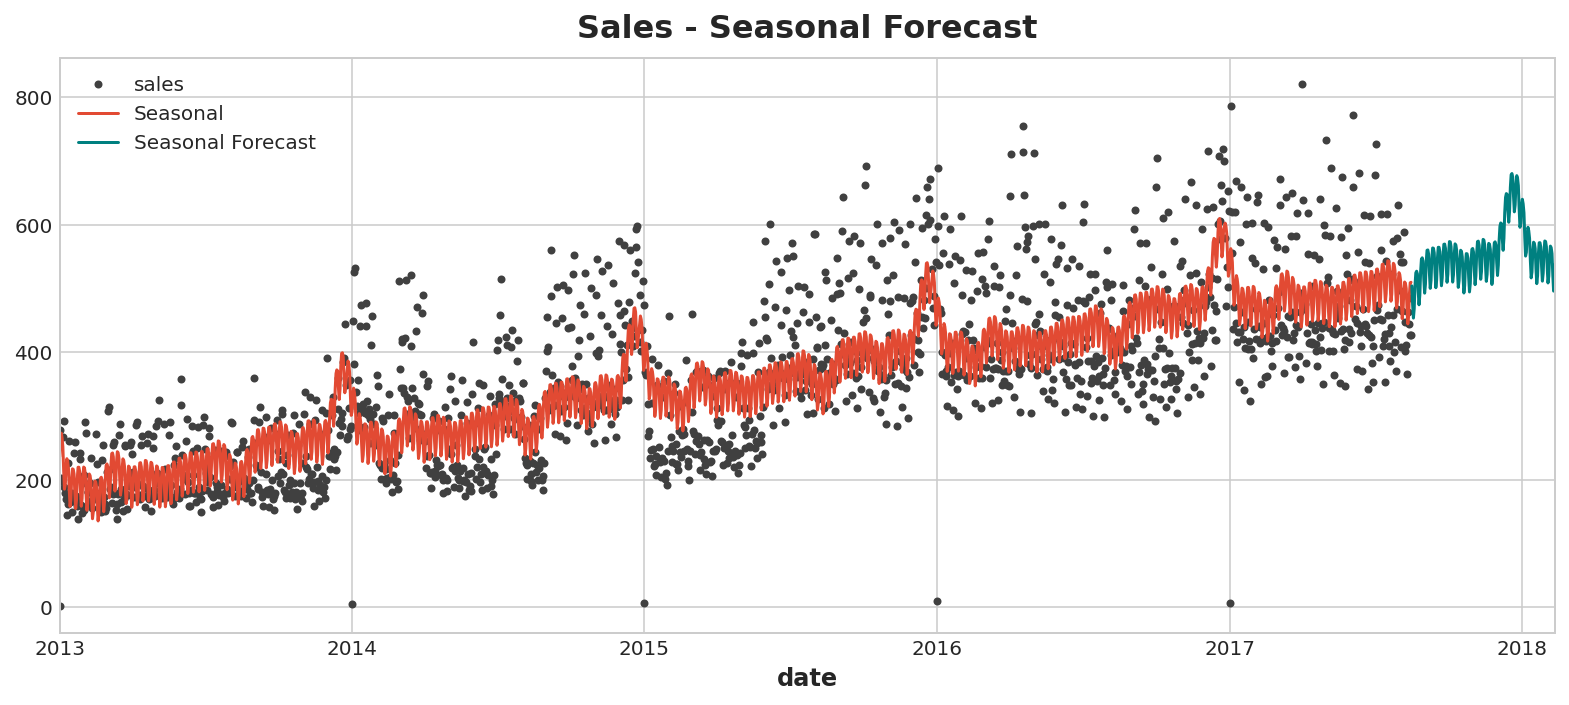

In [40]:
y = grouped_df["sales"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=180)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Sales - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='teal')
_ = ax.legend()

This seasonality is what we would expect, because looking at the graph we see that the sales peaks coincide with the end-of-year festivities. 

### *4.4. Time Series as Features*

This section uses the concept of serial dependency. By this we mean that past values can help to represent a clear structure. 

-As a remainder:  With the past models (trend and seasonality), we trained models that were learning time dependence, not serial dependence.

In [41]:
store_sales = train_data.copy()
store_sales['date'] = pd.to_datetime(store_sales['date'])
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean() 
    .unstack('family')
    .loc['2017', ['sales', 'onpromotion']])
mag_sales = family_sales.loc(axis=1)[:, 'MAGAZINES']

store_sales.head()

sales  onpromotion
store_nbr family     date                          
1         AUTOMOTIVE 2013-01-01    0.0            0
                     2013-01-02    2.0            0
                     2013-01-03    3.0            0
                     2013-01-04    3.0            0
                     2013-01-05    5.0            0

In [42]:
mag_sales.head()

sales onpromotion
family     MAGAZINES   MAGAZINES
date                            
2017-01-01  0.074074         0.0
2017-01-02  7.777778         0.0
2017-01-03  3.500000         0.0
2017-01-04  3.500000         0.0
2017-01-05  3.203704         0.0

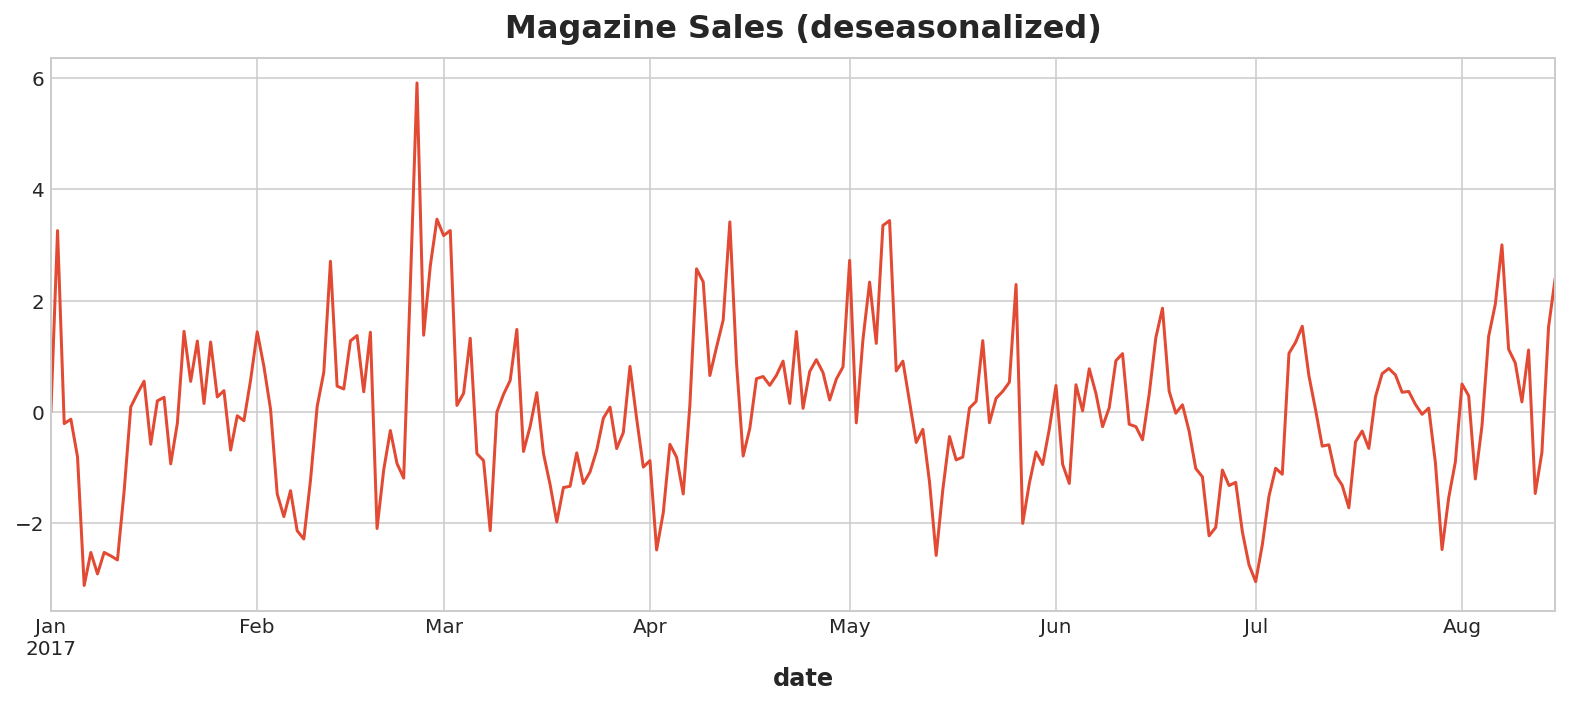

In [43]:
# Plotting the data
y = mag_sales.loc[:, 'sales'].squeeze()

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    constant=True,
    index=y.index,
    order=1,
    seasonal=True,
    drop=True,
    additional_terms=[fourier],
)
X_time = dp.in_sample()
X_time['NewYearsDay'] = (X_time.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X_time, y)
y_deseason = y - model.predict(X_time)
y_deseason.name = 'sales_deseasoned'

ax = y_deseason.plot()
ax.set_title("Magazine Sales (deseasonalized)");

### *4.4.1. Time Series as Features: Lag Plots*

In simple terms, lagging a time series means taking the previous values of a series and using them as a feature to predict the current value. For example, if you are trying to predict the stock market prices for tomorrow, you can use the stock market prices from the day before and the day before that as features to help make your prediction. By using these lagged values, it allows the model to take into account past trends and patterns that might be helpful in predicting the current value.

In [44]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(alpha=0.75,s=3)
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_, y=y_, scatter_kws=scatter_kws, line_kws=line_kws, lowess=True, ax=ax, **kwargs)
    at = AnchoredText(f"{corr:.2f}",prop=dict(size="large"), frameon=True, loc="upper left")
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2 + 10, nrows * 2 + 5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

The graph below plots the lags of the time series and shows their values in relation to each other. The serial dependence of a time series is often seen in such graphs. 
- In this lag graph, it can be seen that there is a certain relationship between sales and previous lags. 

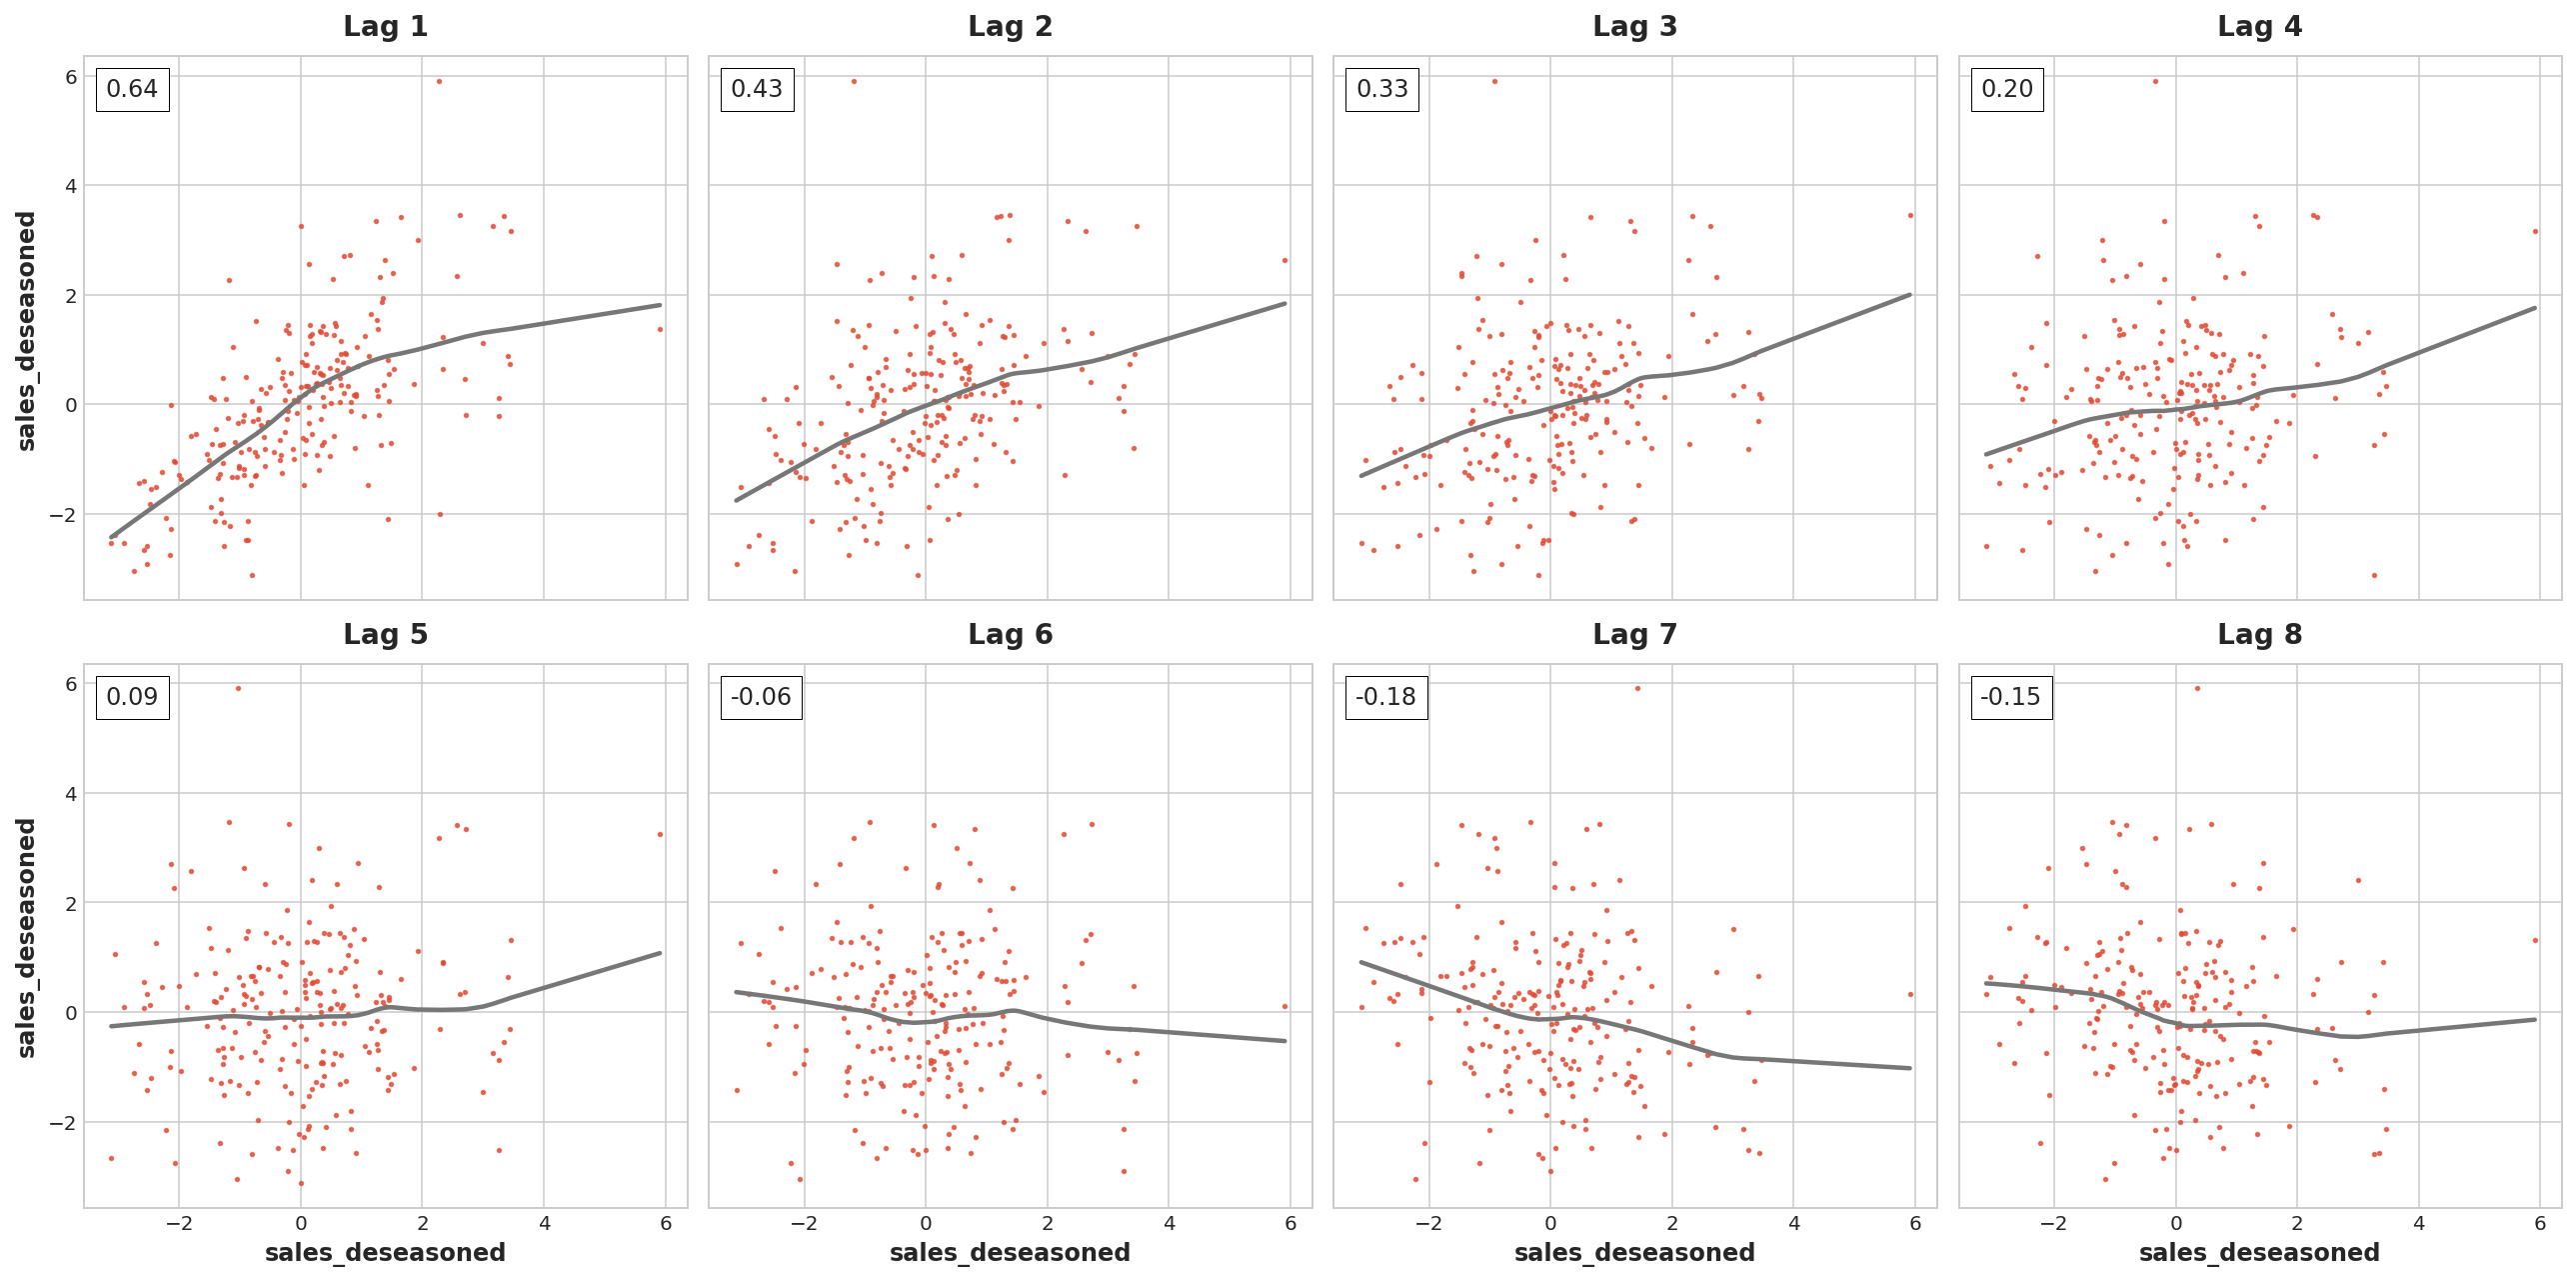

In [45]:
_ = plot_lags(y_deseason, lags=8, nrows=2)

### *4.4.2. Time Series as Features: Partial Autocorrelation*

PACF indicates the correlation of a delay that takes into account all previous delays, i.e. the amount of "new" correlation that the delay contributes. Its usefulness lies in knowing how many lags to use. In the figure below, lags 1 to 2 fall outside the "no correlation" intervals (in orange), so we could choose lags 1 to 2 as characteristics.

- (lag 11 is probably a false positive).

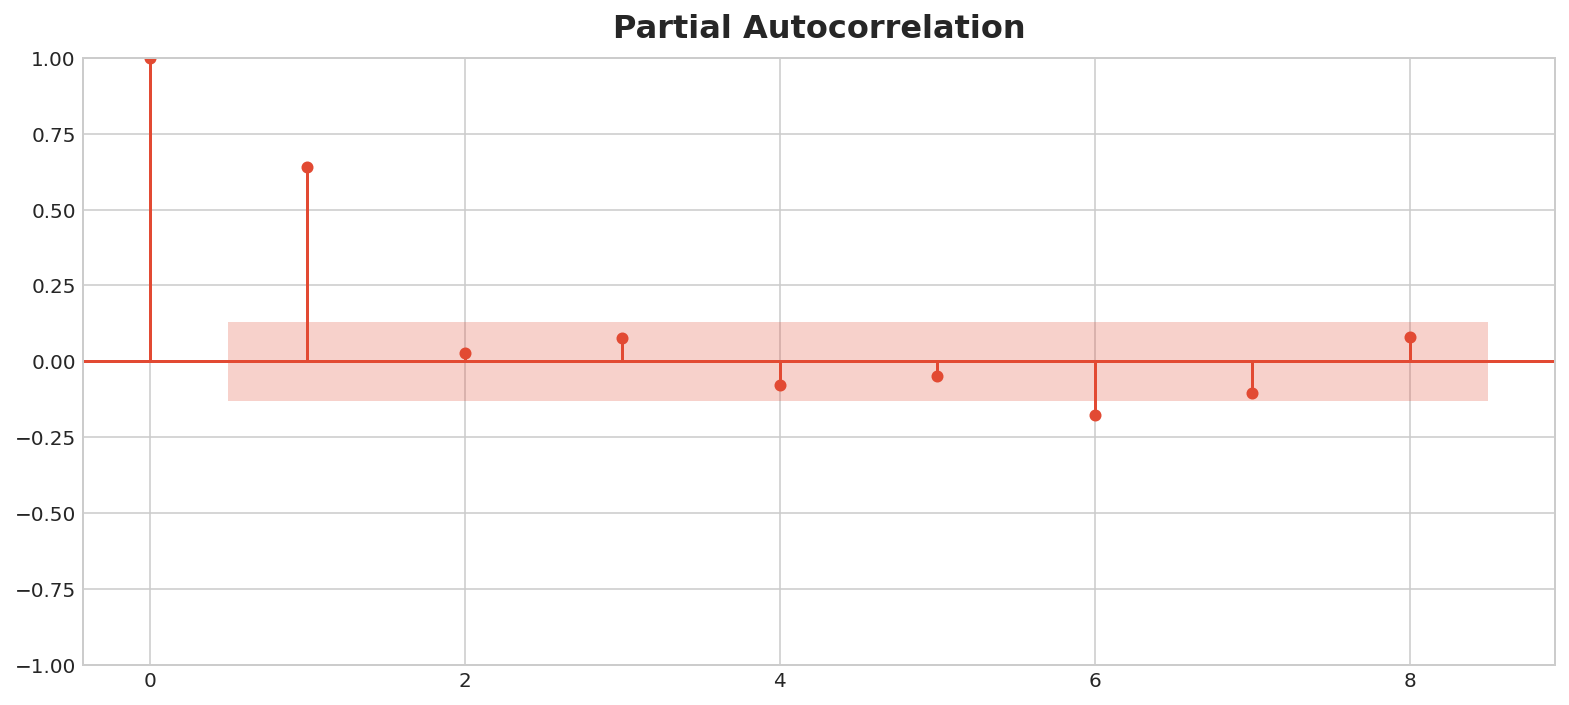

In [46]:
_ = plot_pacf(y_deseason, lags=8)

### *4.4.3. Lags Forecasting*

The forecasts are a little more imprecise, as the lag effect at the predicted points is somewhat evident. These time series are "purely cyclical": they have no obvious trend or seasonality. 


As evidenced in the previous section, especially for the case of shop sales, the time series have trend, seasonality and cycles.

If one wish to include these three elements to build a robust model, we can resort to hybrid models, which comes in the next section. 




In [47]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)

In [48]:
X = make_lags(y_deseason, lags=4)
X = X.fillna(0.0)

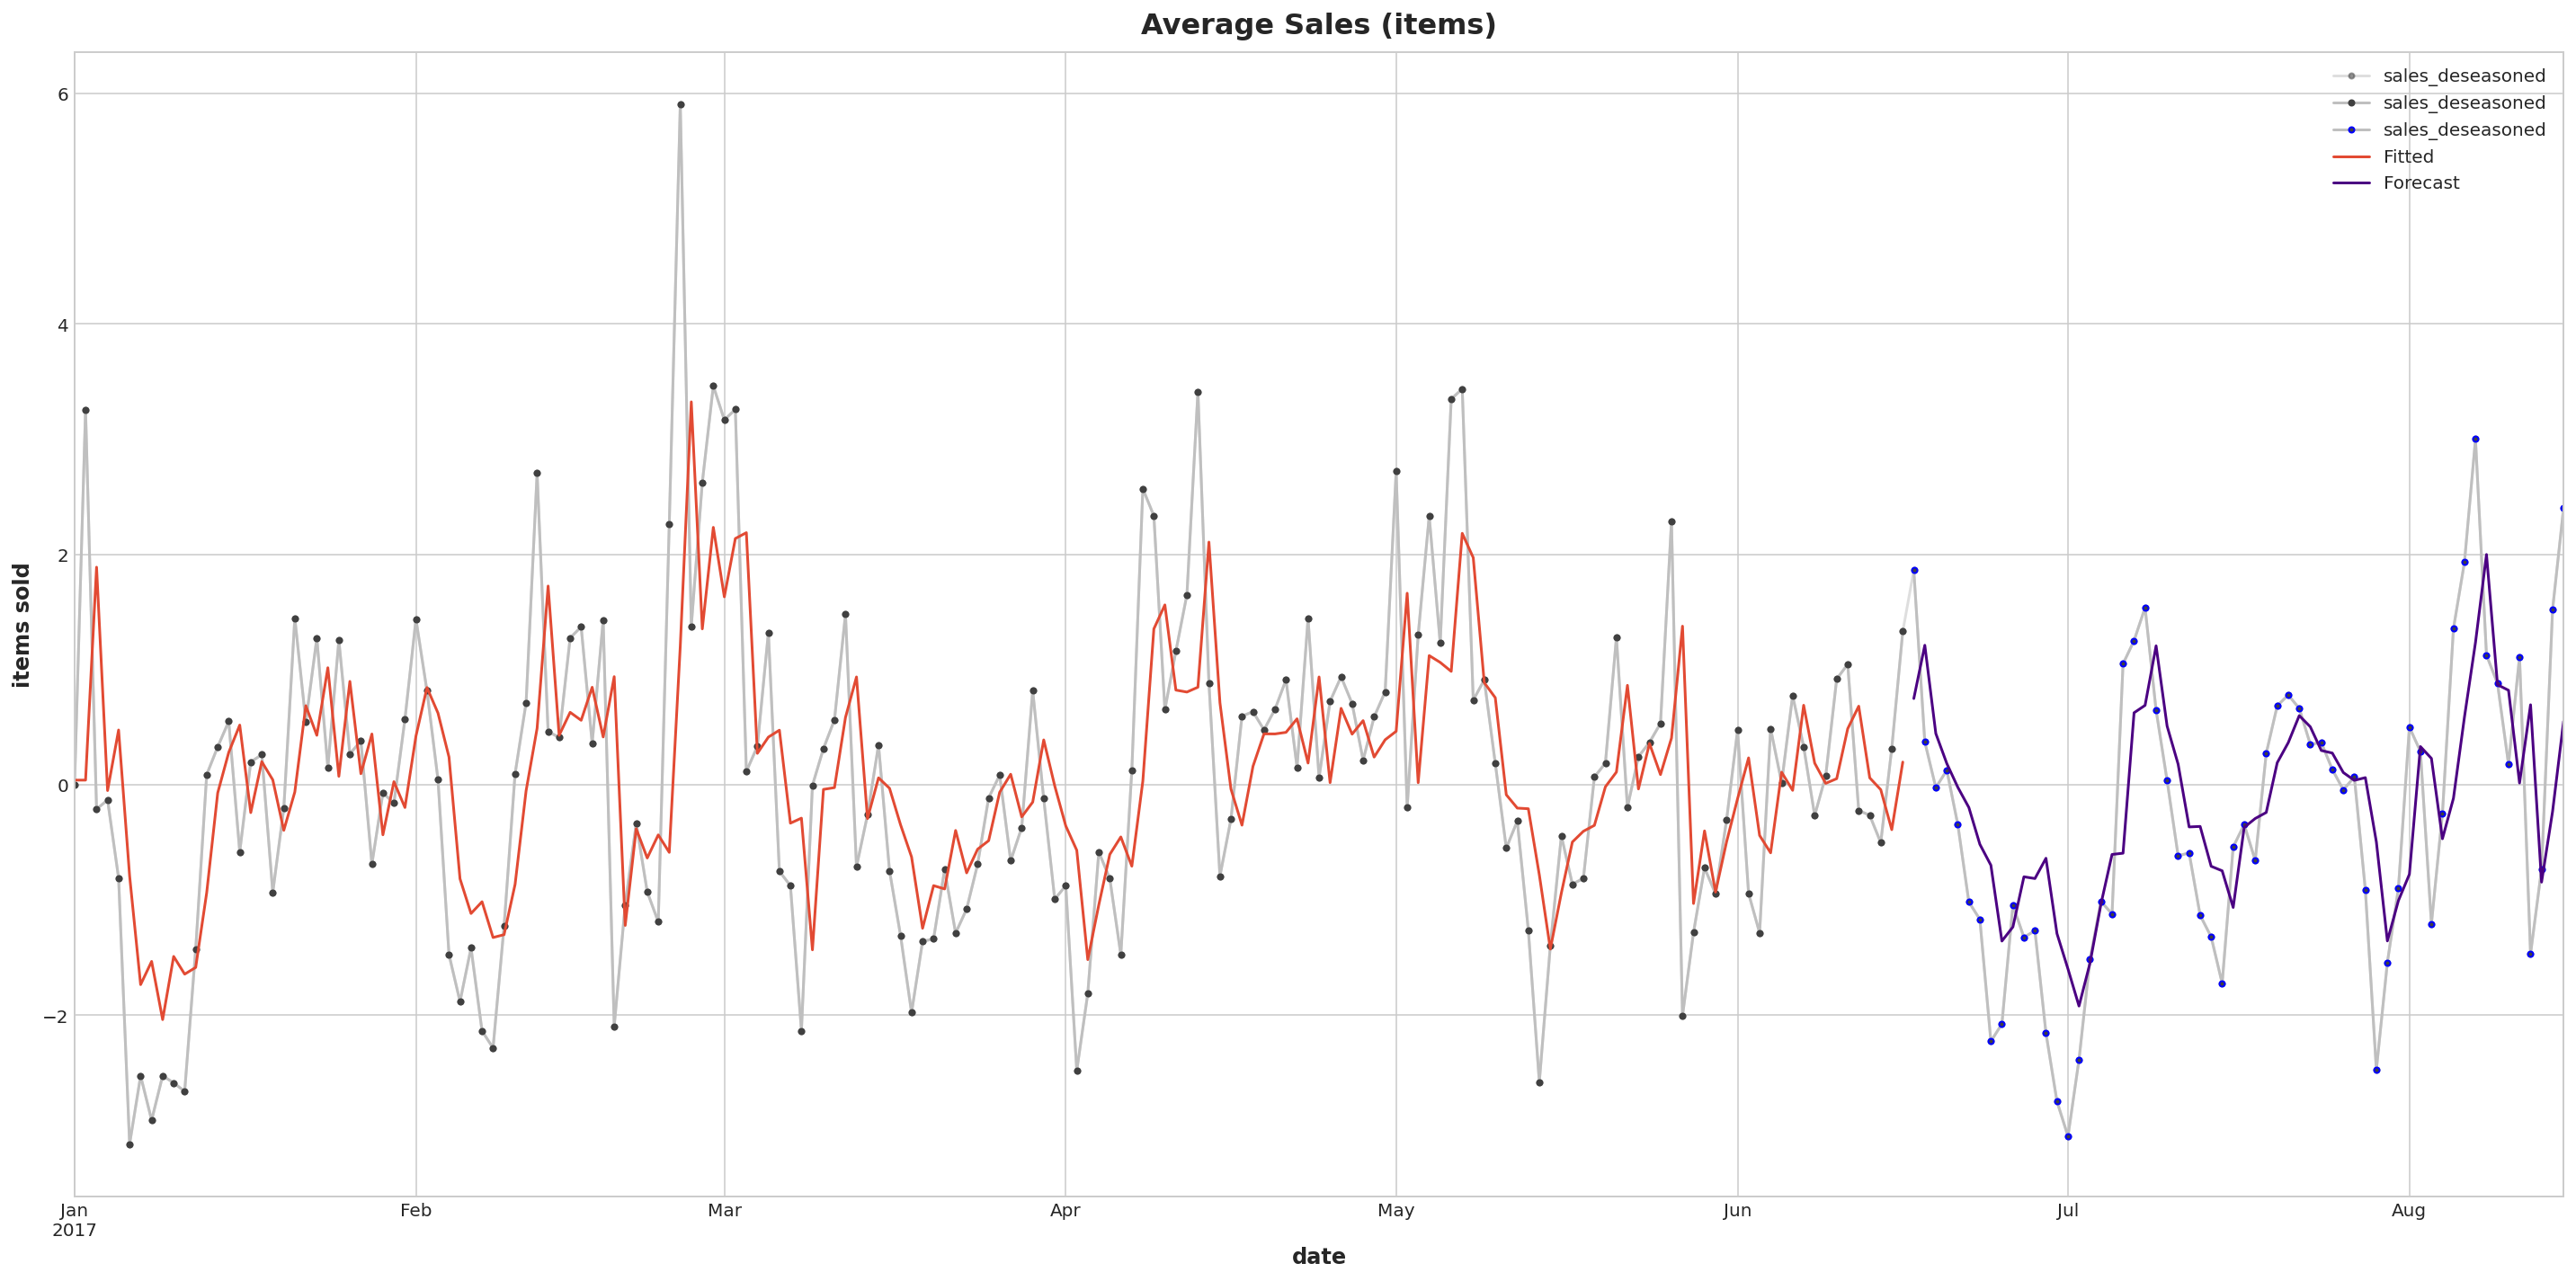

In [49]:
# Plot predictions
# Create target series and data splits
y = y_deseason.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales (items)", ylabel="items sold")
ax = y_train.plot(color="0.75", style=".-", markeredgecolor="0.25", markerfacecolor="0.25", ax=ax)
ax = y_test.plot(color="0.75",style=".-",markeredgecolor="blue", markerfacecolor="0.25", ax=ax)
ax = y_pred.plot(label="Fitted", ax=ax)
_ = y_fore.plot(ax=ax,label="Forecast", color='indigo')
ax.legend()
plt.show()


### *4.5. Hybrid Models*

Quick explanation: Linear regression helps to include "trends", but cannot learn interactions. XGBoost excels at learning "interactions", but fail to include trends. 

Because of this, it can be useful to include "hybrid" models that combine complementary learning algorithms and allow the strengths of one to compensate for the weaknesses of the other.



In [50]:
family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017':]
)

family_sales.head()

sales                                              \
family     AUTOMOTIVE BABY CARE     BEAUTY    BEVERAGES     BOOKS   
date                                                                
2017-01-01   0.092593  0.037037   0.055556    74.222222  0.000000   
2017-01-02  11.481481  0.259259  11.648148  6208.055556  0.481481   
2017-01-03   8.296296  0.296296   7.185185  4507.814815  0.814815   
2017-01-04   6.833333  0.333333   6.888889  3911.833333  0.759259   
2017-01-05   6.333333  0.351852   5.925926  3258.796296  0.407407   

                                                                           \
family     BREAD/BAKERY CELEBRATION     CLEANING        DAIRY        DELI   
date                                                                        
2017-01-01     9.084685    0.129630     7.500000    11.518519    3.629167   
2017-01-02   844.836296   14.203704  2233.648148  1545.000000  539.114833   
2017-01-03   665.124111   10.629630  1711.907407  1204.203704  404.300074   
2017-01-04   594.160611   11.185185  1508.037037  1107.796296  309.397685   
2017-01-05   495.511611   12.444444  1241.833333   829.277778  260.776500   

            ... onpromotion                                       \
family      ...   MAGAZINES     MEATS PERSONAL CARE PET SUPPLIES   
date        ...                                                    
2017-01-01  ...         0.0  0.018519      0.111111     0.018519   
2017-01-02  ...         0.0  0.462963     10.592593     0.537037   
2017-01-03  ...         0.0  0.481481      9.722222     0.444444   
2017-01-04  ...         0.0  0.370370     12.037037     0.444444   
2017-01-05  ...         0.0  8.981481      5.666667     0.000000   

                                                                         \
family     PLAYERS AND ELECTRONICS   POULTRY PREPARED FOODS     PRODUCE   
date                                                                      
2017-01-01                     0.0  0.000000       0.037037    0.129630   
2017-01-02                     0.0  0.259259       1.166667    5.629630   
2017-01-03                     0.0  0.388889       1.351852   56.296296   
2017-01-04                     0.0  0.296296       5.444444  101.277778   
2017-01-05                     0.0  0.296296       0.907407    5.018519   

                                                 
family     SCHOOL AND OFFICE SUPPLIES   SEAFOOD  
date                                             
2017-01-01                        0.0  0.000000  
2017-01-02                        0.0  0.407407  
2017-01-03                        0.0  0.407407  
2017-01-04                        0.0  0.333333  
2017-01-05                        0.0  0.444444  

[5 rows x 66 columns]

Creating a **Boosted Hybrid class**:

In [51]:
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None 

In [52]:
def fit(self, X_1, X_2, y):
    # train model_1
    self.model_1.fit(X_1, y)

    # make predictions
    y_fit = pd.DataFrame(
        self.model_1.predict(X_1), 
        index=X_1.index, columns=y.columns,
    )

    # compute residuals
    y_resid = y - y_fit
    y_resid = y_resid.stack().squeeze() # wide to long

    # train model_2 on residuals
    self.model_2.fit(X_2, y_resid)

    # save column names for predict method
    self.y_columns = y.columns
    # Save data for question checking
    self.y_fit = y_fit
    self.y_resid = y_resid


# Add method to class
BoostedHybrid.fit = fit

Now we can instantiate the model and predict:

In [53]:
def predict(self, X_1, X_2):
    # Predict with model_1
    y_pred = pd.DataFrame(
        self.model_1.predict(X_1), 
        index=X_1.index, columns=self.y_columns,
    )
    y_pred = y_pred.stack().squeeze()  # wide to long

    # Add model_2 predictions to model_1 predictions
    y_pred += self.model_2.predict(X_2)

    return y_pred.unstack()


# Add method to class
BoostedHybrid.predict = predict

In [54]:
# Target series
y = family_sales.loc[:, 'sales']


# X_1: Features for Linear Regression
dp = DeterministicProcess(index=y.index, order=1)
X_1 = dp.in_sample()


# X_2: Features for XGBoost
X_2 = family_sales.drop('sales', axis=1).stack()  # onpromotion feature

# Label encoding for 'family'
le = LabelEncoder()  # from sklearn.preprocessing
X_2 = X_2.reset_index('family')
X_2['family'] = le.fit_transform(X_2['family'])

# Label encoding for seasonality
X_2["day"] = X_2.index.day  # values are day of the month


Train the model

In [55]:
# Base model
model = BoostedHybrid(
    model_1=LinearRegression(),
    model_2=XGBRegressor())

model.fit(X_1, X_2, y)

y_pred = model.predict(X_1, X_2)
y_pred = y_pred.clip(0.0)

In [56]:
# Boosted Hybrid Model using Ridge
model = BoostedHybrid(
    model_1=Ridge(),
    model_2=KNeighborsRegressor(),
)

For this particular scenario, it is seen that the trend learned by XGBoost is not compensated correctly, so the results are not optimal when compared to the model in the previous section, for example. It is up to the user to decide whether to incorporate this interaction factor or to discard it.

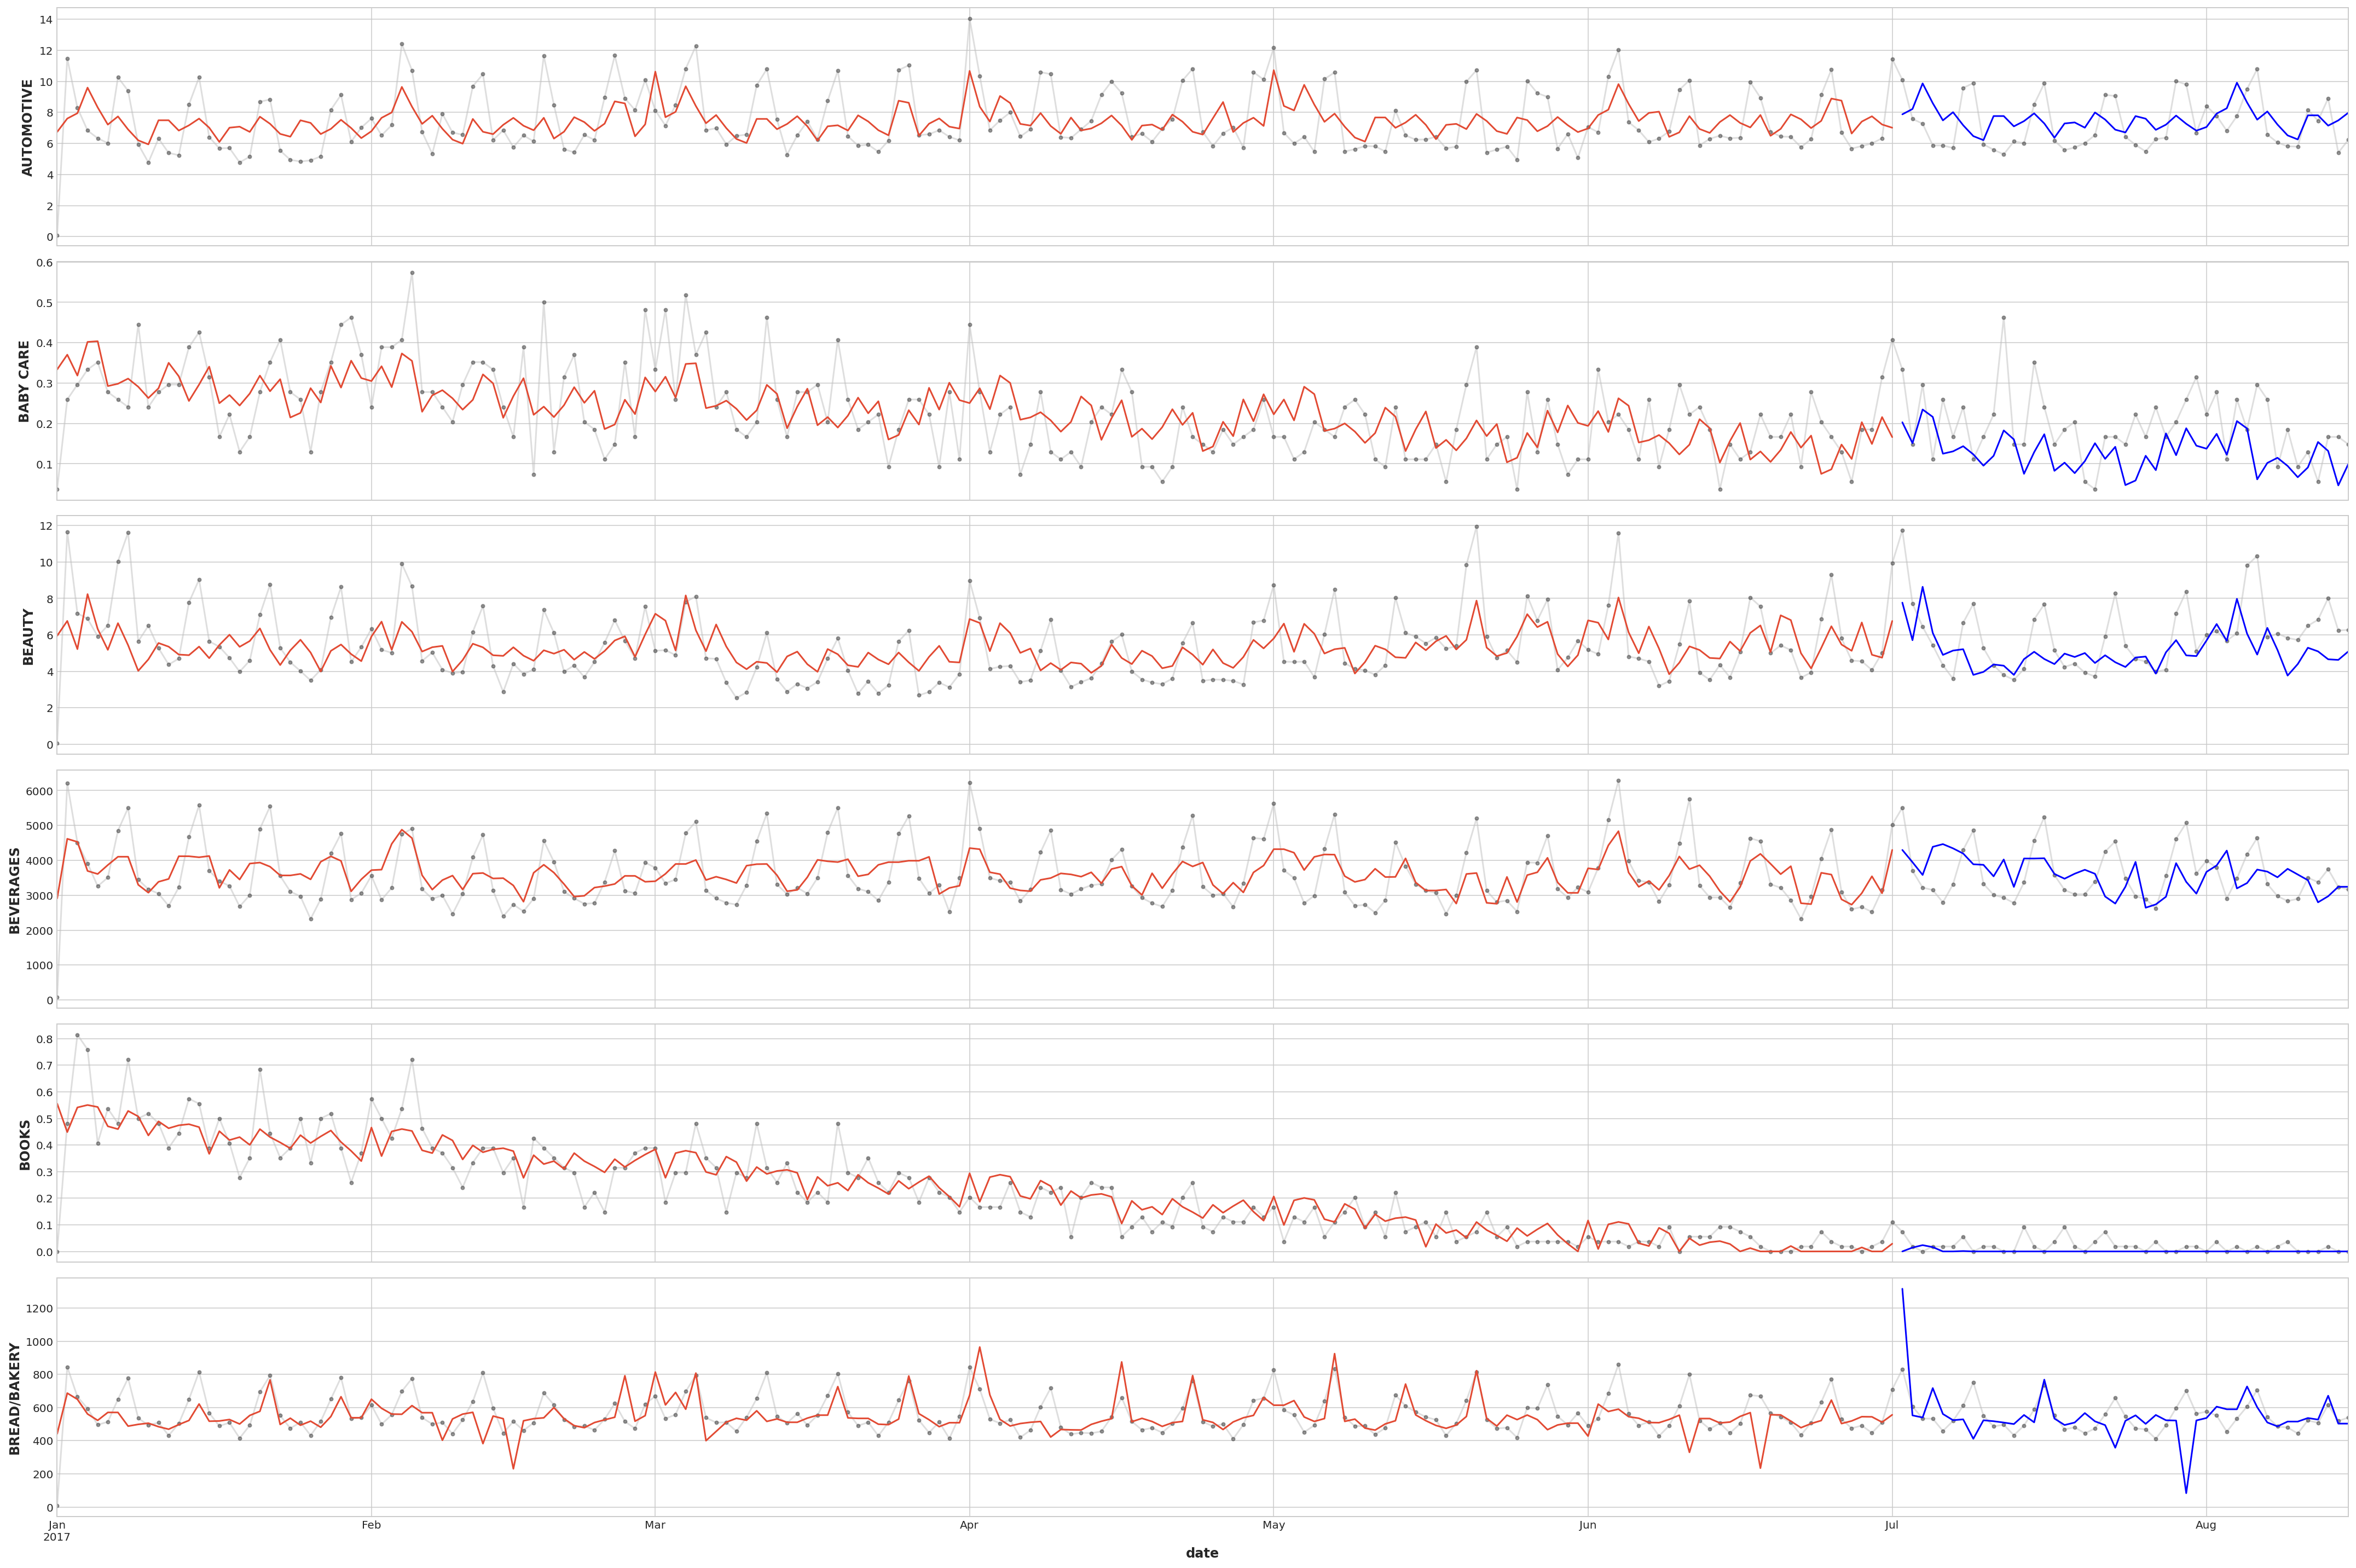

In [57]:
# Split data into train and validation sets
y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":]
X1_train, X1_valid = X_1[: "2017-07-01"], X_1["2017-07-02" :]
X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]

model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)

families = y.columns[0:6]
axs = y.loc(axis=1)[families].plot(subplots=True, 
                                   sharex=True, 
                                   figsize=(30, 20), 
                                   color="0.75",
                                   style=".-",
                                   markeredgecolor="0.25",
                                   markerfacecolor="0.25",
                                   alpha=0.5)
_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='b', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)

### *4.6. Forecasting with Machine Learning*

Real-world forecasting typically demands more than just add 1 lag (1 step in the past) so we may require look at the results of using more lags. We can tackle this using Machine Learning Forecasting.

In [58]:
df = pd.read_csv(path+'train.csv', index_col=0)
df['date'] = pd.to_datetime(df['date'])
df['date'] = df.date.dt.to_period('D')
df = df.set_index(['store_nbr', 'family', 'date']).sort_index()
df

sales  onpromotion
store_nbr family     date                          
1         AUTOMOTIVE 2013-01-01    0.0            0
                     2013-01-02    2.0            0
                     2013-01-03    3.0            0
                     2013-01-04    3.0            0
                     2013-01-05    5.0            0
...                                ...          ...
54        SEAFOOD    2017-08-11    0.0            0
                     2017-08-12    1.0            1
                     2017-08-13    2.0            0
                     2017-08-14    0.0            0
                     2017-08-15    3.0            0

[3000888 rows x 2 columns]

In [59]:
sales_per_family = (df.groupby(['family', 'date']).mean().unstack('family').loc['2017'])
sales_per_family

sales                                              \
family     AUTOMOTIVE BABY CARE     BEAUTY    BEVERAGES     BOOKS   
date                                                                
2017-01-01   0.092593  0.037037   0.055556    74.222222  0.000000   
2017-01-02  11.481481  0.259259  11.648148  6208.055556  0.481481   
2017-01-03   8.296296  0.296296   7.185185  4507.814815  0.814815   
2017-01-04   6.833333  0.333333   6.888889  3911.833333  0.759259   
2017-01-05   6.333333  0.351852   5.925926  3258.796296  0.407407   
...               ...       ...        ...          ...       ...   
2017-08-11   8.166667  0.129630   6.500000  3502.055556  0.000000   
2017-08-12   7.462963  0.055556   6.833333  3376.259259  0.000000   
2017-08-13   8.907407  0.166667   8.018519  3747.296296  0.018519   
2017-08-14   5.407407  0.166667   6.240741  3237.629630  0.000000   
2017-08-15   6.240741  0.148148   6.277778  3162.462963  0.000000   

                                                                           \
family     BREAD/BAKERY CELEBRATION     CLEANING        DAIRY        DELI   
date                                                                        
2017-01-01     9.084685    0.129630     7.500000    11.518519    3.629167   
2017-01-02   844.836296   14.203704  2233.648148  1545.000000  539.114833   
2017-01-03   665.124111   10.629630  1711.907407  1204.203704  404.300074   
2017-01-04   594.160611   11.185185  1508.037037  1107.796296  309.397685   
2017-01-05   495.511611   12.444444  1241.833333   829.277778  260.776500   
...                 ...         ...          ...          ...         ...   
2017-08-11   522.305296   16.111111  1031.148148   831.648148  345.934963   
2017-08-12   507.473111   15.722222  1072.870370   793.592593  290.553574   
2017-08-13   615.976981   10.074074  1143.648148   928.000000  325.801371   
2017-08-14   518.564019   11.000000  1019.111111   797.222222  271.532241   
2017-08-15   539.966574   11.055556  1082.851852   753.833333  276.582463   

            ... onpromotion                                        \
family      ...   MAGAZINES      MEATS PERSONAL CARE PET SUPPLIES   
date        ...                                                     
2017-01-01  ...         0.0   0.018519      0.111111     0.018519   
2017-01-02  ...         0.0   0.462963     10.592593     0.537037   
2017-01-03  ...         0.0   0.481481      9.722222     0.444444   
2017-01-04  ...         0.0   0.370370     12.037037     0.444444   
2017-01-05  ...         0.0   8.981481      5.666667     0.000000   
...         ...         ...        ...           ...          ...   
2017-08-11  ...         0.0  22.925926      9.000000     0.000000   
2017-08-12  ...         0.0   0.000000      8.703704     0.000000   
2017-08-13  ...         0.0   0.000000      9.240741     0.000000   
2017-08-14  ...         0.0   0.000000      8.722222     0.000000   
2017-08-15  ...         0.0   0.000000      8.814815     0.000000   

                                                                          \
family     PLAYERS AND ELECTRONICS    POULTRY PREPARED FOODS     PRODUCE   
date                                                                       
2017-01-01                0.000000   0.000000       0.037037    0.129630   
2017-01-02                0.000000   0.259259       1.166667    5.629630   
2017-01-03                0.000000   0.388889       1.351852   56.296296   
2017-01-04                0.000000   0.296296       5.444444  101.277778   
2017-01-05                0.000000   0.296296       0.907407    5.018519   
...                            ...        ...            ...         ...   
2017-08-11                0.000000  27.407407       0.537037    6.000000   
2017-08-12                0.018519   0.111111       0.277778    6.000000   
2017-08-13                0.000000   0.185185       0.222222    5.907407   
2017-08-14                0.000000   0.129630       0.148148    6.018519   
2017-08-15     

In [60]:
# Function to add lags
def make_multistep_target(ts, steps):
    return pd.concat({f'y_step_{i + 1}': ts.shift(-i) for i in range(steps)},axis=1)

In [61]:
y = sales_per_family.loc[:, 'sales']

# 5 lag features
X = make_lags(y, lags=5).dropna()

y = make_multistep_target(y, steps=16).dropna()

y, X = y.align(X, join='inner', axis=0)

In [62]:
le = LabelEncoder()
X = (X
    .stack('family')  # wide to long
    .reset_index('family')  # convert index to column
    .assign(family=lambda x: le.fit_transform(x.family))  # label encode
)
y = y.stack('family')  # wide to long

display(y) 

y_step_1     y_step_2     y_step_3  \
date       family                                                              
2017-01-06 AUTOMOTIVE                     6.018519    10.259259     9.388889   
           BABY CARE                      0.277778     0.259259     0.240741   
           BEAUTY                         6.518519    10.037037    11.611111   
           BEVERAGES                   3507.277778  4848.518519  5503.648148   
           BOOKS                          0.537037     0.481481     0.722222   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      364.955648   403.601334   377.313980   
           PREPARED FOODS                84.698648    87.836796    88.735963   
           PRODUCE                     2257.140589  2609.180150  3122.895724   
           SCHOOL AND OFFICE SUPPLIES    30.111111    49.333333    57.481481   
           SEAFOOD                       20.488333    20.346852    20.801037   

                                          y_step_4     y_step_5     y_step_6  \
date       family                                                              
2017-01-06 AUTOMOTIVE                     5.944444     4.777778     6.314815   
           BABY CARE                      0.444444     0.240741     0.277778   
           BEAUTY                         5.648148     6.500000     5.277778   
           BEVERAGES                   3448.203704  3171.740741  3046.870370   
           BOOKS                          0.500000     0.518519     0.481481   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      316.436093   533.497054   416.454018   
           PREPARED FOODS                77.173000    91.886760   100.384963   
           PRODUCE                     1792.220910  2079.319469  2418.970157   
           SCHOOL AND OFFICE SUPPLIES    51.907407    63.222222    85.203704   
           SEAFOOD                       17.116296    25.553963    24.209519   

                                          y_step_7     y_step_8     y_step_9  \
date       family                                                              
2017-01-06 AUTOMOTIVE                     5.388889     5.240741     8.500000   
           BABY CARE                      0.296296     0.296296     0.388889   
           BEAUTY                         4.370370     4.703704     7.777778   
           BEVERAGES                   2693.722222  3226.037037  4667.296296   
           BOOKS                          0.388889     0.444444     0.574074   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      464.596557   344.051740   313.780869   
           PREPARED FOODS               102.248148    86.627444    77.344130   
           PRODUCE                     2675.105815  2111.133423  2168.535465   
           SCHOOL AND OFFICE SUPPLIES   100.277778    64.407407    59.759259   
           SEAFOOD                       23.512852    18.419852    18.481130   

                                         y_step_10    y_step_11    y_step_12  \
date       family                                                              
2017-01-06 AUTOMOTIVE                    10.259259     6.407407     5.685185   
           BABY CARE                      0.425926     0.314815     0.166667   
           BEAUTY                         9.037037     5.648148     5.351852   
           BEVERAGES                   5580.611111  3700.370370  3409.796296   
           BOOKS                          0.555556     0.388889     0.500000   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      305.270204   278.819870   468.857370   
           PREPARED FOODS                84.796537    78.791444    96.286926   
           PRODUCE                     2663.076241  1670.264889  2198.854500   
           SCHOOL AND OFFICE SUPPLIES  

### *4.6.1. XGBoost Multioutput model*

XGBoost can't produce multiple outputs for regression tasks. But by applying the direct reduction strategy, we can  use it to produce multi-step forecasts.

In [63]:
model = MultiOutputRegressor(XGBRegressor())
model.fit(X, y)

y_pred = pd.DataFrame(
    model.predict(X),
    index=y.index,
    columns=y.columns,
).clip(0.0)

Here you can see the value of including a higher number of lags in the model. At first glance, the predicted points are a good match to the actual values, so predictions can be more accurate.

- It should be remembered that we should avoid getting the model too close to the actual values, as this can lead to overfitting.

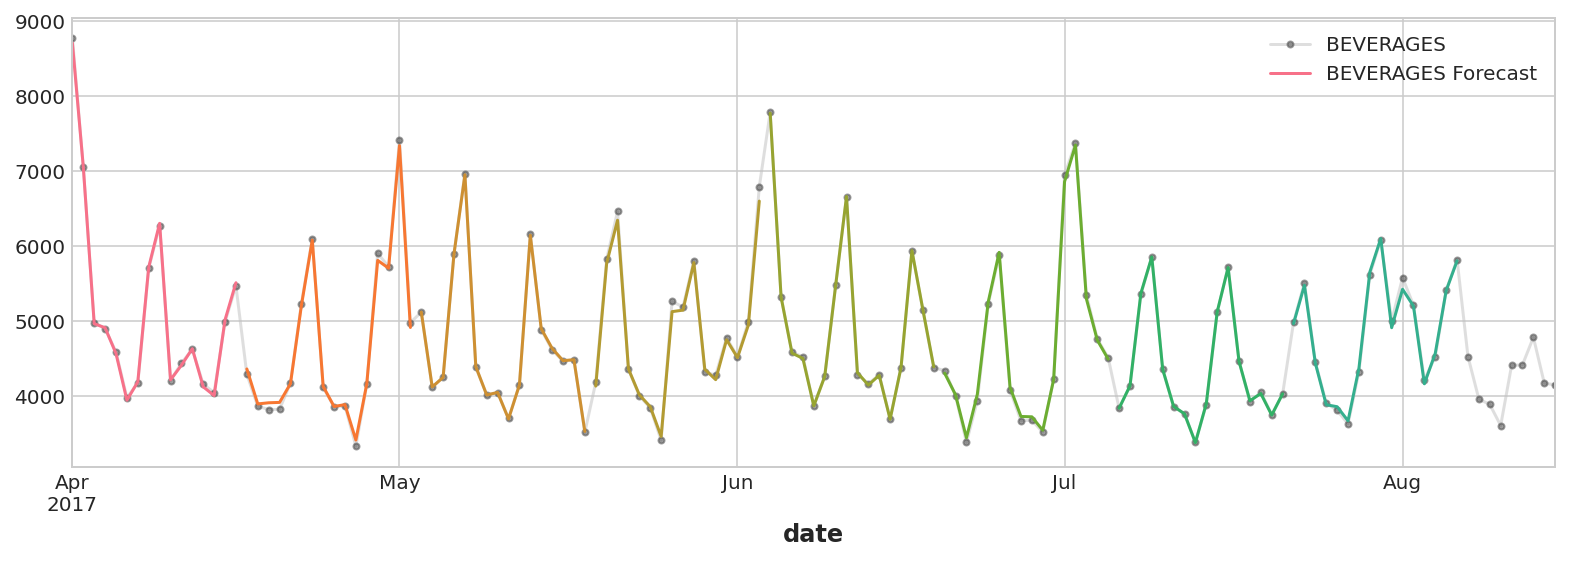

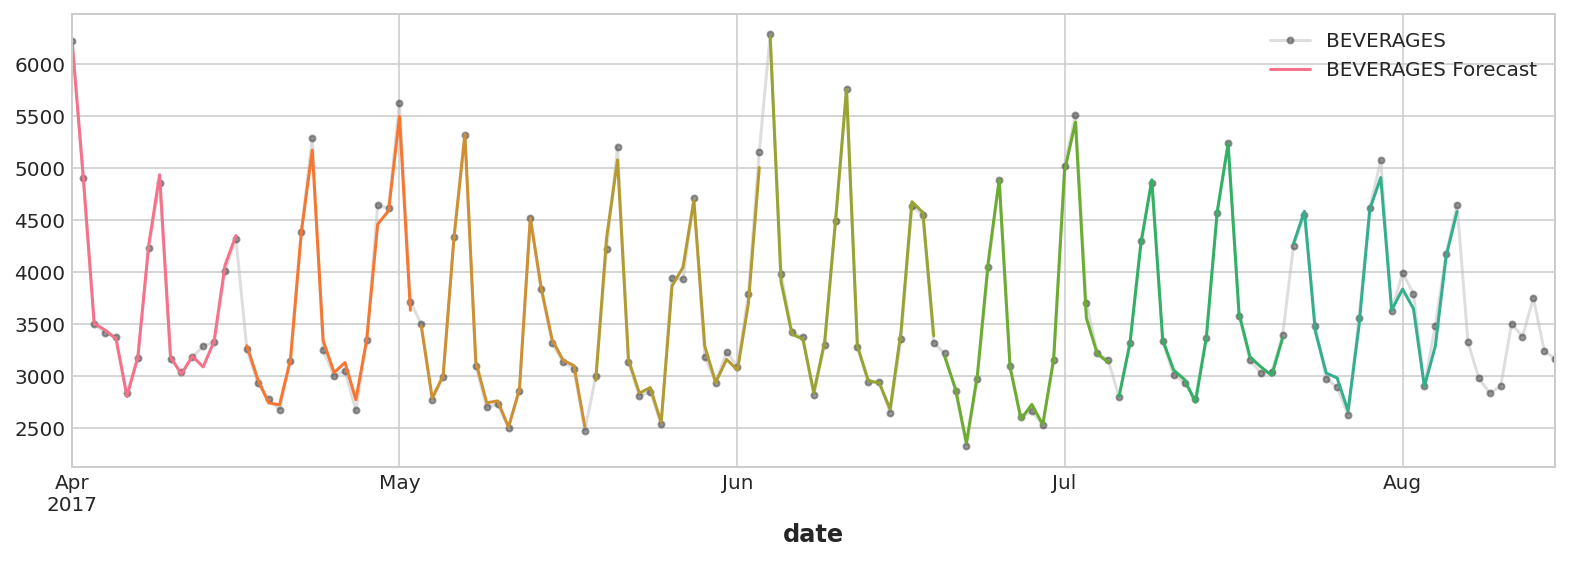

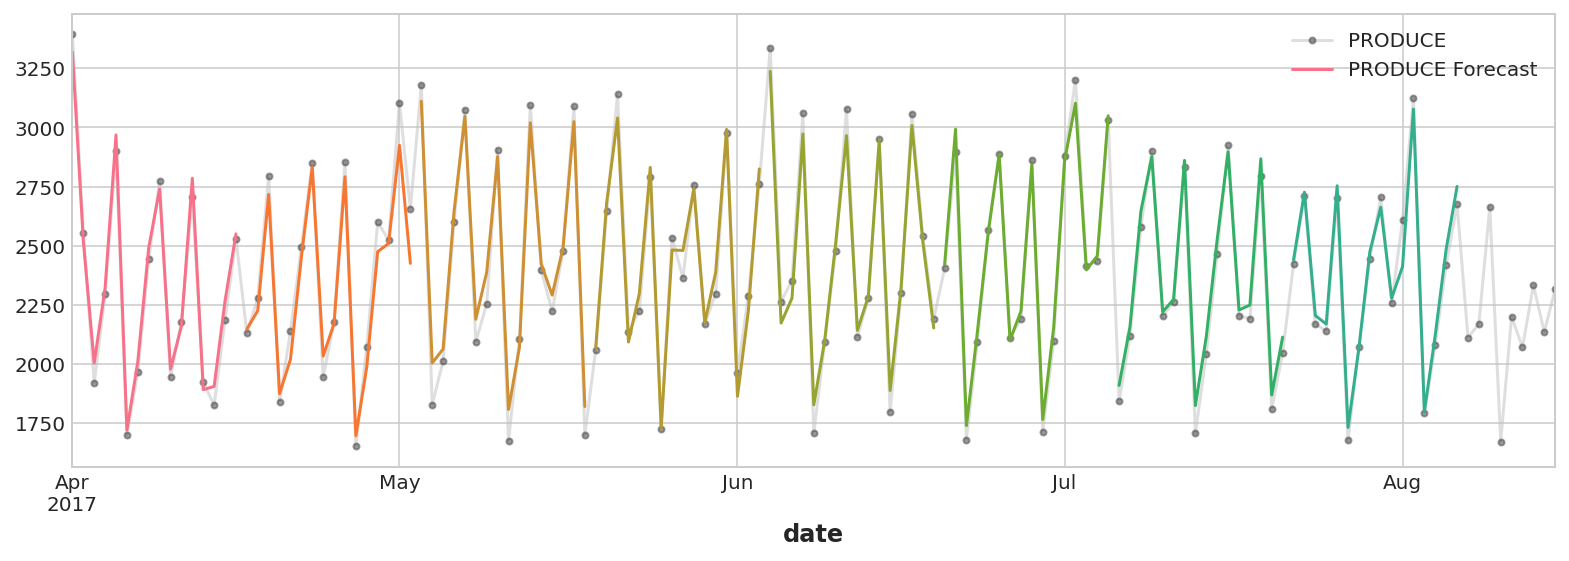

In [64]:
FAMILY = 'GROCERY I'
START = '2017-04-01'
EVERY = 16

y_pred_ = y_pred.xs(FAMILY, level='family', axis=0).loc[START:]
y_ = family_sales.loc[START:, 'sales'].loc[:, FAMILY]

fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax = y_.plot(**plot_params, ax=ax, alpha=0.5)
ax = plot_multistep(y_pred_, ax=ax, every=EVERY)
_ = ax.legend([FAMILY, FAMILY + ' Forecast'])

FAMILY = 'BEVERAGES'
START = '2017-04-01'
EVERY = 16

y_pred_ = y_pred.xs(FAMILY, level='family', axis=0).loc[START:]
y_ = family_sales.loc[START:, 'sales'].loc[:, FAMILY]
_ = ax.legend([FAMILY, FAMILY + ' Forecast'])

fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax = y_.plot(**plot_params, ax=ax, alpha=0.5)
ax = plot_multistep(y_pred_, ax=ax, every=EVERY)
_ = ax.legend([FAMILY, FAMILY + ' Forecast'])

FAMILY = 'PRODUCE'
START = '2017-04-01'
EVERY = 16

y_pred_ = y_pred.xs(FAMILY, level='family', axis=0).loc[START:]
y_ = family_sales.loc[START:, 'sales'].loc[:, FAMILY]


fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax = y_.plot(**plot_params, ax=ax, alpha=0.5)
ax = plot_multistep(y_pred_, ax=ax, every=EVERY)
_ = ax.legend([FAMILY, FAMILY + ' Forecast'])

___________

### *4.7. References:* 

Special thanks to the following authors, who provided the basis for this notebook. Detailed theory on the models used is available in Ryan's course. You can also take a look at Maryna's notebook, which demonstrates a masterclass in the use of classes and models. 

- https://www.kaggle.com/code/ryanholbrook/forecasting-with-machine-learning
- https://www.kaggle.com/code/howoojang/first-kaggle-notebook-following-ts-tutorial/notebook
- https://www.kaggle.com/code/maricinnamon/store-sales-time-series-forecast-visualization/notebook#4.-Time-Series-as-Features
- https://www.kaggle.com/code/kashishrastogi/store-sales-analysis-time-serie?scriptVersionId=81112640
